# Прогнозирование оттока клиентов телекоммуникационной компании

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов и иметь возможность прогнозировать, кто из клиентов планирует отказаться от услуг связи. Клиентам из этой категории предлагать промокоды и специальные условия .   
Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.  
Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет.   
Подключение может быть двух типов:
  - через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия»)
  - оптоволоконный кабель (Fiber optic).

Также доступны дополнительные услуги:
- антивирус (DeviceProtection)
- блокировка небезопасных сайтов (OnlineSecurity);
- выделенная линия технической поддержки (TechSupport);
- облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- стриминговое телевидение (StreamingTV)
- каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года.
Возможна оплата счёта разными способами и получение электронного чека.
Информация о договорах актуальна на 1 февраля 2020 года.  
  

«ТелеДом» собрал и предоставили обезличенные персональные данные о некоторых клиентах:  
contract_new.csv — информация о договоре;  
personal_new.csv — персональные данные клиента;  
internet_new.csv — информация об интернет-услугах;  
phone_new.csv — информация об услугах телефонии.  

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года  

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 187 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


## 1. Установка и загрузка библиотек и датафреймов



In [ ]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as stats
from scipy import stats
from scipy.stats import chi2_contingency

! pip install catboost
from catboost import CatBoostClassifier

from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     KFold,
                                     RandomizedSearchCV)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler




In [ ]:
RANDOM_STATE = 271123

In [ ]:
%%capture
# install phik (if not installed yet)
import sys

!"{sys.executable}" -m pip install phik
import phik

from phik import resources
from phik.binning import bin_data
from phik.decorators import *
from phik.report import plot_correlation_matrix

In [ ]:
!pip install sweetviz
import sweetviz as sv

     |████████████████████████████████| 15.1 MB 2.2 MB/s eta 0:00:01


#### Функции для анализа данных

In [ ]:
""" Общая информация по датафрейму """

def df_info(dataframe):
    print('Общая информация по датафрейму:')
    display(dataframe.info())
    print('\nПервые 10 строк:')
    display(dataframe.head())
    print('\nПоследние 10 строк:')
    display(dataframe.tail())
    print('\nПропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nОписание датафрейма:')
    display(dataframe.describe(include = 'all'))
    print('\nЯвные дубликаты:')
    display(dataframe.duplicated().sum())
    for i in dataframe.columns:
        print(f'Признак "{i}" имеет {len(dataframe[i].unique())} уникальных значений:')
        print(dataframe[i].unique(), '\n')

In [ ]:
""" Snakecase для названий и lowercase для значений (избегаем неявных дубликатов) столбцов """
def snake_df(dataframe):
    # Добавляем подчеркивания перед заглавными буквами и приводим все к нижнему регистру
    dataframe.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower() for column in dataframe.columns]

    # Переименовываем столбец "customer_i_d" в "customer_id"
    #dataframe = dataframe.rename(columns={'customer_i_d': 'customer_id'})

    # Приводим все строки к нижнему регистру
    for col in dataframe.columns:
        if dataframe[col].dtype == 'object':
            dataframe[col] = dataframe[col].str.lower()

    return dataframe


In [ ]:
""" Строит графики распределения признаков для анализа """
def plot_features_1(dataframe):
    n_rows = dataframe.shape[1] // 4 + (dataframe.shape[1] % 4 > 0)
    n_cols = 4

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6))
    axs = axs.flatten()
    fig.suptitle('Распределение признаков', fontsize=14)

    for i, col in enumerate(dataframe.columns.drop('customer_id')):
        if dataframe[col].dtype in ['int64', 'float64']:
            if dataframe[col].nunique() > 10:
                axs[i].hist(dataframe[col], alpha=0.5, edgecolor='black', color='#4CC9F0')
                axs[i].get_xaxis().set_ticks([])
            else:
                dataframe[col].value_counts().plot(kind='bar', ax=axs[i], color='#4CC9F0')
        elif dataframe[col].dtype == 'object':
            value_counts = dataframe[col].value_counts()
            if value_counts.shape[0] > 10:
                axs[i].pie(value_counts.values, colors=sns.color_palette('Spectral'))
            else:
                axs[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.0f%%', colors=sns.color_palette('Spectral'))
        axs[i].set_title(col, fontsize=12)

    for i in range(len(dataframe.columns) - 1, n_rows*n_cols):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

### Загрузка данных

In [ ]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [ ]:
#internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/internet_new.csv')

In [ ]:
#personal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/personal_new.csv')

In [ ]:
#phone = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phone_new.csv')

## Исследовательский анализ и предобработка данных

Рассмотрим каждый датафрейм, посмотрим на распределение призкаков, выполним анализ и предобработку там, где необходимо

**Датафрейм Contact (информация о договоре)**

In [ ]:
snake_df(contract)
contract = contract.rename(columns={'customer_i_d': 'customer_id'})
df_info(contract)

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Первые 10 строк:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.6
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.5



Последние 10 строк:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
7038,6840-resvb,2018-02-01,no,one year,yes,mailed check,84.80,2035.2
7039,2234-xaduh,2014-02-01,no,one year,yes,credit card (automatic),103.20,7430.4
7040,4801-jzazl,2019-03-01,no,month-to-month,yes,electronic check,29.60,325.6
7041,8361-ltmkd,2019-07-01,no,month-to-month,yes,mailed check,74.40,520.8
7042,3186-ajiek,2014-08-01,no,two year,yes,bank transfer (automatic),105.65,7251.82



Пропуски:


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


Описание датафрейма:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7446-kqiso,2014-02-01,no,month-to-month,yes,electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN



Явные дубликаты:


0

Признак "customer_id" имеет 7043 уникальных значений:
['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '4801-jzazl' '8361-ltmkd'
 '3186-ajiek'] 

Признак "begin_date" имеет 77 уникальных значений:
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2

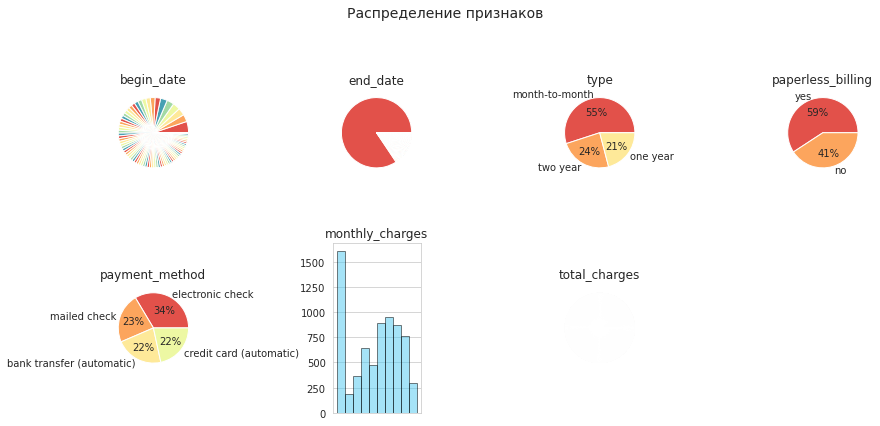

In [ ]:
plot_features_1(contract)

``customer_id``` -идентификатор абонента
* ```begin_date``` - дата начала действия договора, всего 77 оригинальных значений, тип object
* ```end_date``` - дата окончания действия договор, всего 67 оригинальных значений, тип object
* ```type``` - тип оплаты: ежемесячный, годовой и тд, категория в 3 оригинальных значения
* ```paperless_billing``` - электронный расчётный лист
* ```payment_metho``` - способ оплаты
* ```monthly_charges``` - ежемесячные расходы на услуги
* ```total_charges``` - общие расходы на услуги, сохранён строкой, поэтому строится на кроговом графике, распределения не видно

1. Признаки begin_date и end_date содержат информацию о дате и месяце начала и окончания действия договора.   
Если end_date содержит значение "no", то договор был активен на 01.02.2020. Оба признака нужно удалить из датафрейма, т.к. приведут к ошибочным предсказаниям модели при использовании более поздних дат.   
Перед их удалением создадим признаки active_contract и duration_month (длительность договора в месяцах).    

2. Признак active_contract будет содержать 0, если значение end_date 'no', и 1, если end_date содержит дату. Это будет наш целевой признак.  
  
3. Признак duration будет содержать информацию о продолжительности действия договора.

4. Признак total_charges имеет тип object и требует преобразования в тип float64.

In [ ]:
#Изменение типа 'total_charges'
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = 0
contract['total_charges'] = contract['total_charges'].astype('float64')

In [ ]:
# Создание признака "active_contract"
contract['active_contract'] = 0
contract.loc[contract['end_date'] == 'no', 'active_contract'] = 1

In [ ]:
# Изменение типа "begin_date"
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

#  Изменение типа "end_date"
contract.loc[contract['end_date'] == 'no', 'end_date'] = '2020-02-01'
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

# Создание признака "duration"
contract['duration'] = ((contract['end_date'] - contract['begin_date']).dt.days).astype(int)

Посмотрим на распределение данных в столбце 'total_charges' после изменения типа:

In [ ]:
contract['total_charges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

Минимальное значение равно нулю. Выберем из дата фрейма все такие записи:

In [ ]:
contract.query('total_charges == 0')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,duration
488,4472-lvygi,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,0.0,1,0
753,3115-czmzd,2020-02-01,2020-02-01,two year,no,mailed check,20.25,0.0,1,0
936,5709-lvoeq,2020-02-01,2020-02-01,two year,no,mailed check,80.85,0.0,1,0
1082,4367-nuyao,2020-02-01,2020-02-01,two year,no,mailed check,25.75,0.0,1,0
1340,1371-dwpaz,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,0.0,1,0
3331,7644-omvmy,2020-02-01,2020-02-01,two year,no,mailed check,19.85,0.0,1,0
3826,3213-vvolg,2020-02-01,2020-02-01,two year,no,mailed check,25.35,0.0,1,0
4380,2520-sgtta,2020-02-01,2020-02-01,two year,no,mailed check,20.00,0.0,1,0
5218,2923-arzlg,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,0.0,1,0
6670,4075-wkniu,2020-02-01,2020-02-01,two year,no,mailed check,73.35,0.0,1,0


Записи с 'total_charges' равными нулю относятся к февралю 2020-г. Это совсем новые пользователи сервиса. Удалим эти 11 строк, т.к. в обучении моделей они не будут полезны:

In [ ]:
#оставляем в датафрейме записи, соответствующие условию 'total_charges' > 0
contract = contract[contract['total_charges'] > 0].reset_index()

Рассмотрим более подробно распределение платежей

In [ ]:
""" Функция для постоения гистограммы распределения количественных признаков"""

def dataframe_hist(col, bins):

    mean_ = col.mean()
    median_ = col.median()

    plt.figure(figsize=(12, 4))
    plt.title(f"Распределение в {col.name}", fontsize=14, fontweight='bold')
    sns.histplot(col, kde=True, color='#4CC9F0', ec='#3ca0c0', bins=bins)
    plt.ylabel('количество')

    plt.axvline(x=mean_, label=f'среднее={int(mean_)}', lw=1.5, c='#f72585')
    plt.axvline(x=median_, label=f'медиана={int(median_)}', lw=1.5, c='#7209b7')
    plt.legend(facecolor='#edf9fd', edgecolor='#13addd')

    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.15, linestyle='--')
    plt.show()

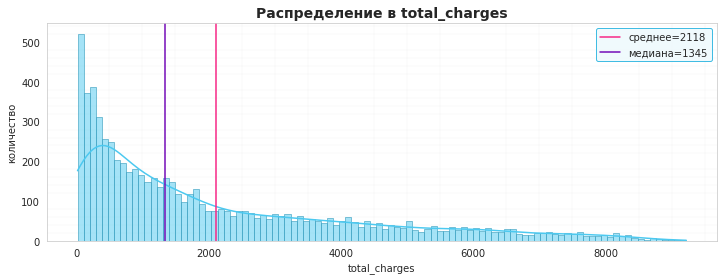

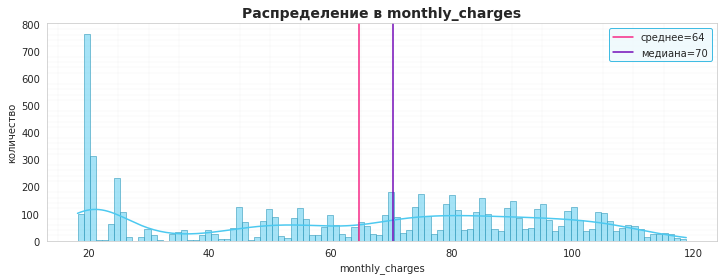

In [ ]:
for i in [('total_charges', 100), ('monthly_charges', 100)]:
    dataframe_hist(contract[i[0]], bins=i[-1])

1. Распределение в total_charges скошено вправо.
2. В monthly_charges тех, кто платит меньше значительно больше чем тех, кто платит больше.   
Позже попробуем создать новый признак с категориями по месячному платежу:  
до 22 - эконом  
от 23 до 45 - средний 1  
от 46 до 80 - средний 2  
свыше 80 - vip

Посмотрим на распределение по месяцам подключений и оттока

In [ ]:
""" Функция для постоения столбчатого графика"""
def plot_monthly_bar_chart(df, date_column, value_column):

    # Создаем временный столбец 'month' путем извлечения месяца из столбца даты
    df['month'] = pd.to_datetime(df[date_column]).dt.to_period('M')
    # Группируем данные по месяцам и суммируем значения
    monthly_data = df.groupby('month')[value_column].count().reset_index()

    # Создаем столбчатую диаграмму
    plt.figure(figsize=(10,6))
    sns.barplot(x='month', y=value_column, data=monthly_data, color='#4CC9F0')
    plt.title('Monthly ' + value_column)
    plt.xlabel('месяц')
    plt.ylabel('количество')

    plt.tick_params(axis='x', labelsize=6)
    plt.xticks(rotation=90)

    plt.show()

    # Удаляем временный столбец 'month'
    df = df.drop(columns=['month'],inplace=True)

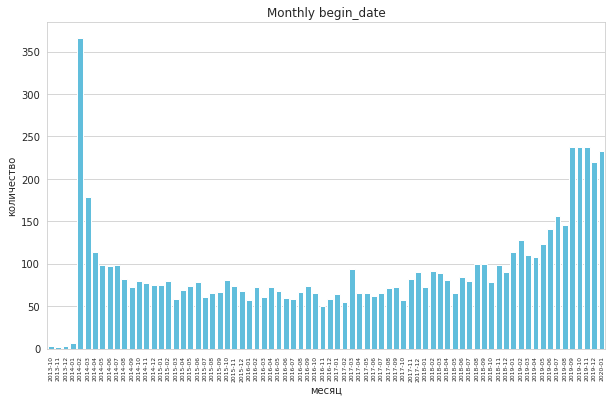

In [ ]:
plot_monthly_bar_chart(contract,'begin_date', 'begin_date')

Что видно из графика:
  - февраль и март 2014-го - всплеск подключений
  - далее до января 2019-го года количество новых клиентов стабильно меньше 50-100 в месяц
  - с января 2019-го года наблюдается планомерный рост подключений и с октября 2019-го компания имеет приток в 200+ новых клиентов в месяц

На диаграмме виден всплеск подключений в феврале и марте 2014 года.
Стоит уточнить у компании причину этого рывка, а пока удалим эту часть данных, до чтобы модель на них не ориентировалась.

In [ ]:
initial_count = contract.shape[0]
contract = contract[contract['begin_date'] > '2014-03-01'].reset_index(drop=True)
deleted_percent = (1 - contract.shape[0] / initial_count) * 100
print(f"Удалили {deleted_percent:.2f}% данных")

Удалили 7.95% данных


Посмотрим на отток клиентов end_date

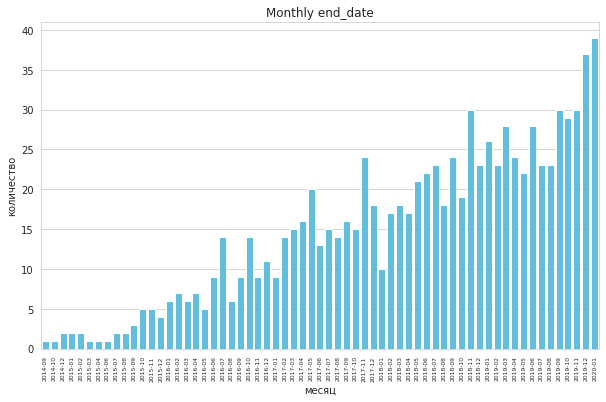

In [ ]:
churn = contract[contract['end_date'] != '2020-02-01'].reset_index()
plot_monthly_bar_chart(churn,'end_date', 'end_date')

На лицо явная проблема с оттоком клиентов, котличество пользователей, отказавшихся от обслуживания растет, а в декабре 2019-го года количество достигло максимума.

**Датафрейм Intenet (информация об интернет-услугах)**

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Первые 10 строк:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no



Последние 10 строк:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
5512,6840-resvb,dsl,yes,no,yes,yes,yes,yes
5513,2234-xaduh,fiber optic,no,yes,yes,no,yes,yes
5514,4801-jzazl,dsl,yes,no,no,no,no,no
5515,8361-ltmkd,fiber optic,no,no,no,no,no,no
5516,3186-ajiek,fiber optic,yes,no,yes,yes,yes,yes



Пропуски:


customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64


Описание датафрейма:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8740-cryfy,fiber optic,no,no,no,no,no,no
freq,1,3096,3498,3088,3095,3473,2810,2785



Явные дубликаты:


0

Признак "customer_id" имеет 5517 уникальных значений:
['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '4801-jzazl' '8361-ltmkd'
 '3186-ajiek'] 

Признак "internet_service" имеет 2 уникальных значений:
['dsl' 'fiber optic'] 

Признак "online_security" имеет 2 уникальных значений:
['no' 'yes'] 

Признак "online_backup" имеет 2 уникальных значений:
['yes' 'no'] 

Признак "device_protection" имеет 2 уникальных значений:
['no' 'yes'] 

Признак "tech_support" имеет 2 уникальных значений:
['no' 'yes'] 

Признак "streaming_t_v" имеет 2 уникальных значений:
['no' 'yes'] 

Признак "streaming_movies" имеет 2 уникальных значений:
['no' 'yes'] 



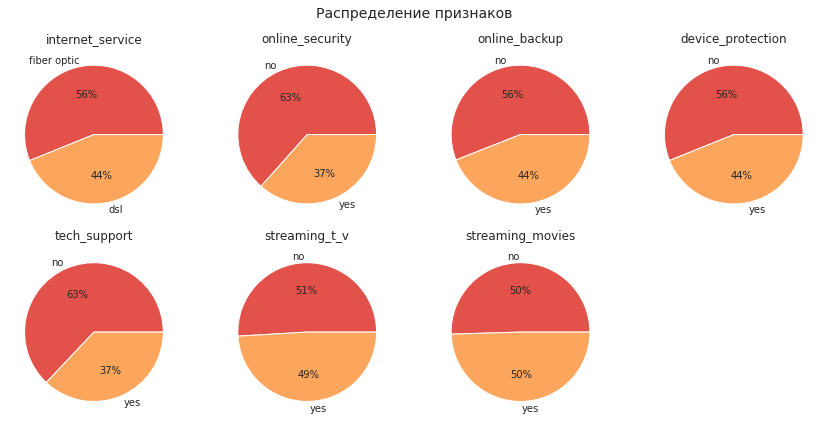

In [ ]:
snake_df(internet)
internet = internet.rename(columns={'customer_i_d': 'customer_id'})
df_info(internet)
plot_features_1(internet)

Содержит категориальные признаки и отражает информацию о типе интернета и подключены или нет дополнительные услуги. Строк меньше, чем в contract. С типами данных всё хорошо, пропусков нет.
* ```internet_service```- тип интернета: fiber optic или dsl
* ```online_security``` - подключена ли блокировка небезопасных файлов
* ```online_backup``` - подключено ли облачное хранилище
* ```device_protection``` - подключён ли антивирус
* ```tech_support``` - выделена ли линия технической поддержки
* ```streaming_tv``` - подключено ли стриминговое телевидение
* ```streaming_movies``` - подключён ли онлайн-кинотеатр

**Датафрейм Personal (персональные данные клиента)**

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Первые 10 строк:


,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no



Последние 10 строк:


,customer_id,gender,senior_citizen,partner,dependents
7038,6840-resvb,male,0,yes,yes
7039,2234-xaduh,female,0,yes,yes
7040,4801-jzazl,female,0,yes,yes
7041,8361-ltmkd,male,1,yes,no
7042,3186-ajiek,male,0,no,no



Пропуски:


customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


Описание датафрейма:


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7446-kqiso,male,NaN,no,no
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN



Явные дубликаты:


0

Признак "customer_id" имеет 7043 уникальных значений:
['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '4801-jzazl' '8361-ltmkd'
 '3186-ajiek'] 

Признак "gender" имеет 2 уникальных значений:
['female' 'male'] 

Признак "senior_citizen" имеет 2 уникальных значений:
[0 1] 

Признак "partner" имеет 2 уникальных значений:
['yes' 'no'] 

Признак "dependents" имеет 2 уникальных значений:
['no' 'yes'] 



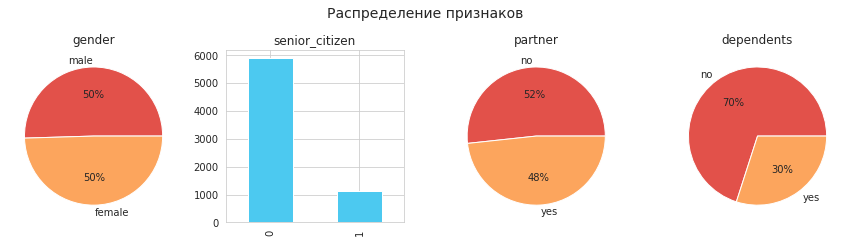

In [ ]:
snake_df(personal)
personal = personal.rename(columns={'customer_i_d': 'customer_id'})
df_info(personal)
plot_features_1(personal)

- ```customer_id``` - id пользователей, количество оригинальных значений совпадает с количеством строк в датасете

все остальные признаки - бинарные флаги:

- ```gender``` - пол
- ```senior_citizen``` - пенсионер
- ```partner``` в браке ли
- ```dependents``` - наличие детей

Пропусков и явных дубликатов нет

Признак senior_citizen имеет тип int64 и содержит числовые значения 0/1, тогда когда как остальные категориальные признаки представлены как 'yes'/'no'. Похоже на ошибку, изменим тип senior_citizen с числа на строку:

In [ ]:
# Меняем тип 'senior_citizen'
personal['senior_citizen'] = personal['senior_citizen'].replace({1: 'yes', 0: 'no'})

**Датафрейм Phone (информация об услугах телефонии)**

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Первые 10 строк:


,customer_id,multiple_lines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes



Последние 10 строк:


,customer_id,multiple_lines
6356,2569-wgero,no
6357,6840-resvb,yes
6358,2234-xaduh,yes
6359,8361-ltmkd,yes
6360,3186-ajiek,no



Пропуски:


customer_id       0
multiple_lines    0
dtype: int64


Описание датафрейма:


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,7446-kqiso,no
freq,1,3390



Явные дубликаты:


0

Признак "customer_id" имеет 6361 уникальных значений:
['5575-gnvde' '3668-qpybk' '9237-hqitu' ... '2234-xaduh' '8361-ltmkd'
 '3186-ajiek'] 

Признак "multiple_lines" имеет 2 уникальных значений:
['no' 'yes'] 



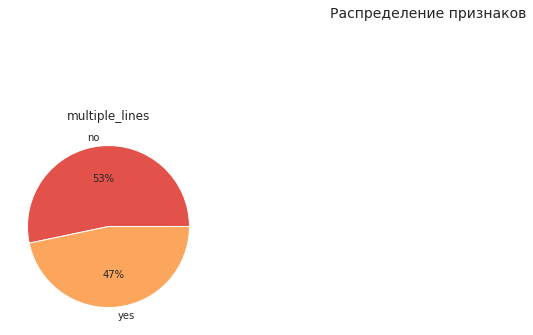

In [ ]:
snake_df(phone)
phone = phone.rename(columns={'customer_i_d': 'customer_id'})
df_info(phone)
plot_features_1(phone)

- ```customer_id``` - id пользователей, количество оригинальных значений совпадает с количеством строк в датасете
- ```multiple_lines``` - возможность подключения телефона к нескольким линиям одновременно: есть/нет

Пропусков и явных дубликатов нет

## Объединение данных

Выполним объединение данных в одну таблицу по столбцу customer_id и продолжим предобработку и анализ

In [ ]:
#contract = contract.drop(columns=['month'])

In [ ]:
df = contract.merge(personal, on='customer_id', how='left') \
    .merge(phone, on='customer_id', how='left') \
    .merge(internet, on='customer_id', how='left')
df.shape

(6473, 23)

Посмотрим на информацию об объединенной таблице:

In [ ]:
display(df.info())
display(df.sample(3))
display(df.isnull().sum().sort_values(ascending=False))
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6473 entries, 0 to 6472
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              6473 non-null   int64         
 1   customer_id        6473 non-null   object        
 2   begin_date         6473 non-null   datetime64[ns]
 3   end_date           6473 non-null   datetime64[ns]
 4   type               6473 non-null   object        
 5   paperless_billing  6473 non-null   object        
 6   payment_method     6473 non-null   object        
 7   monthly_charges    6473 non-null   float64       
 8   total_charges      6473 non-null   float64       
 9   active_contract    6473 non-null   int64         
 10  duration           6473 non-null   int64         
 11  gender             6473 non-null   object        
 12  senior_citizen     6473 non-null   object        
 13  partner            6473 non-null   object        
 14  dependen

None

,index,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,...,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
2307,2532,9825-ycxwz,2016-09-01,2020-02-01,one year,yes,bank transfer (automatic),101.10,4145.1,1,...,no,no,no,fiber optic,no,no,yes,yes,yes,yes
2354,2585,9624-egdeq,2017-01-01,2020-02-01,two year,no,mailed check,19.80,732.6,1,...,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968,2151,2560-wbwxf,2014-06-01,2020-02-01,two year,yes,bank transfer (automatic),24.15,1642.2,1,...,no,no,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


streaming_movies     1413
streaming_t_v        1413
tech_support         1413
device_protection    1413
online_backup        1413
online_security      1413
internet_service     1413
multiple_lines        636
senior_citizen          0
dependents              0
partner                 0
index                   0
customer_id             0
duration                0
active_contract         0
total_charges           0
monthly_charges         0
payment_method          0
paperless_billing       0
type                    0
end_date                0
begin_date              0
gender                  0
dtype: int64

,index,monthly_charges,total_charges,active_contract,duration
count,6473.000000,6473.000000,6473.000000,6473.000000,6473.000000
mean,3531.625676,63.532721,1868.791409,0.856635,817.212112
std,2032.655881,29.575347,1867.366748,0.350471,627.809044
min,0.000000,18.250000,19.050000,0.000000,28.000000
25%,1766.000000,35.000000,398.160000,1.000000,245.000000
50%,3528.000000,69.750000,1188.100000,1.000000,700.000000
75%,5302.000000,88.950000,2853.810000,1.000000,1308.000000
max,7042.000000,118.600000,8751.050000,1.000000,2132.000000


Наблюдаем одинаковое количество пропусков в объединенной таблице в столбцах с услугами.   
С уверенностью утверждать, что причина пропусков заключается в отказе от доп. услуг или имеет место технический сбой, нельзя.
Удалять данные в таком объеме неправильно, поэтому заполним пропуски отдельной третьей категорий под названием 'no_value':

In [ ]:
# Столбцы для заполнения пропусков
columns_to_update = ['multiple_lines', 'internet_service', 'online_security',
                     'online_backup', 'device_protection', 'tech_support',
                     'streaming_t_v', 'streaming_movies']
# Заполняем пропуски
df[columns_to_update] = df[columns_to_update].fillna('no_value')

## Исследовательский анализ и предобработка данных объединённого датафрейма

Создадим несколько новых признаков по категориям и удалим столбцы с датами, т.к. они точно не пригодятся для обучения, а в корреляционной матрице будут только лишней информацией

In [ ]:
# количество активных услуг
df['sum_services'] = df[['multiple_lines', 'online_security', 'online_backup', \
                         'device_protection', 'tech_support', 'streaming_t_v', \
                         'streaming_movies']].apply(lambda x: x.eq('yes').sum(), axis=1)

# факт наличия дополнительных услуг
df['add_services'] = df[['online_security', 'online_backup', \
                         'device_protection', 'tech_support', \
                         'streaming_t_v', 'streaming_movies']] \
                          .apply(lambda x: 'yes' if 'yes' in x.values else 'no', axis=1)


# для создания категорий по ежемесячным платежам
def categorize_monthly_charges(x):
    if x < 22:
        return 4
    elif x >= 23 and x < 45:
        return 3
    elif x >= 46 and x < 80:
        return 2
    else:
        return 1
df['payment_category'] = df['monthly_charges'].apply(categorize_monthly_charges)

df = df.drop(columns=['begin_date', 'end_date'])

Создадим два датафрейма с активными пользователями и пользователями в оттоке и с помощью библиотеки Sweetviz составим портреты пользователей

In [ ]:
df_churn = df[df['active_contract'] == 0]
df_active = df[df['active_contract'] == 1]
comparison = sv.compare(df_active, df_churn)

                                             |          | [  0%]   00:00 -> (? left)


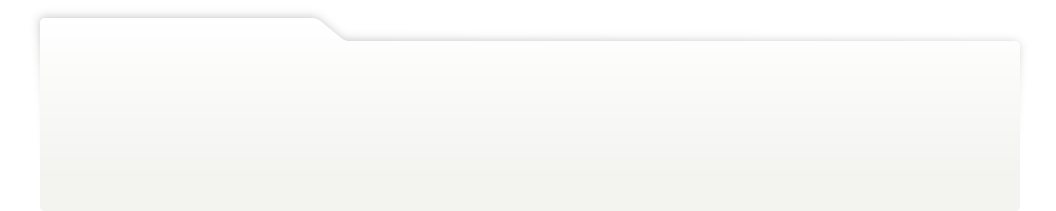
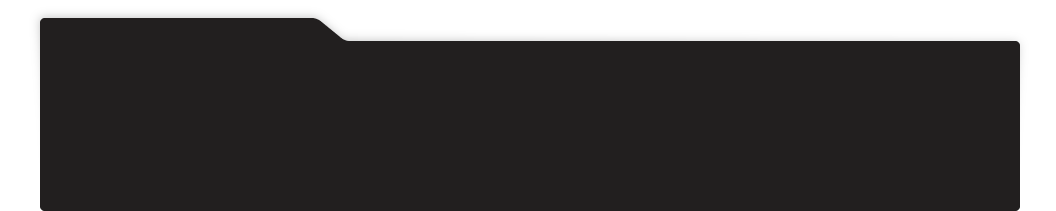
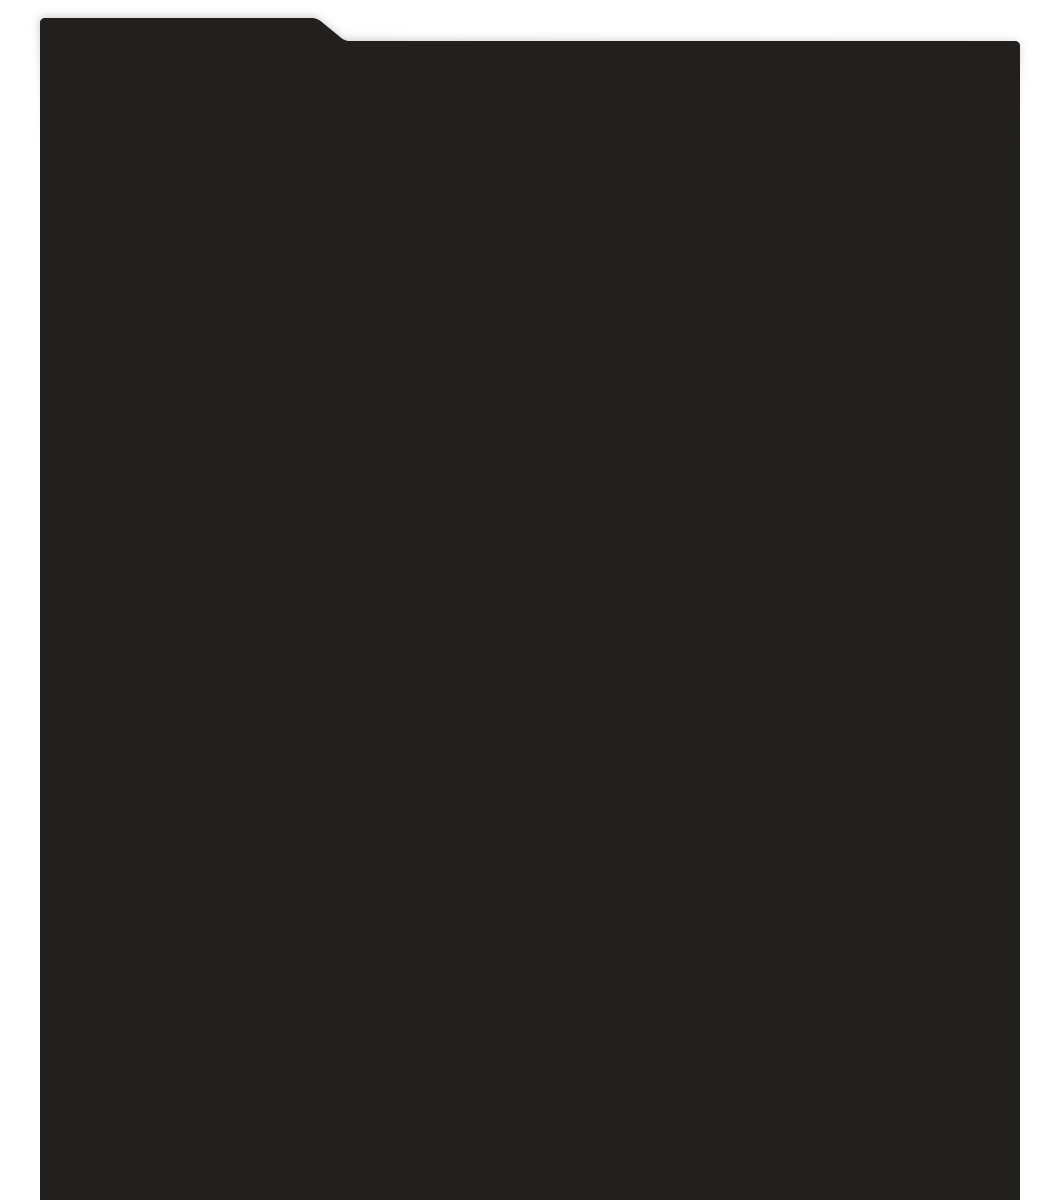
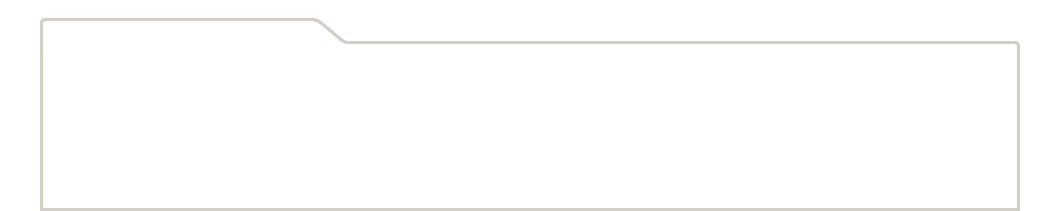
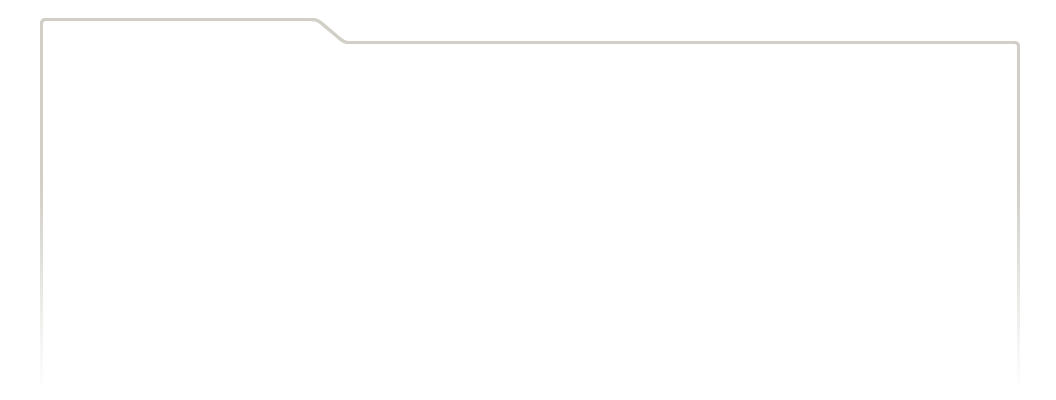
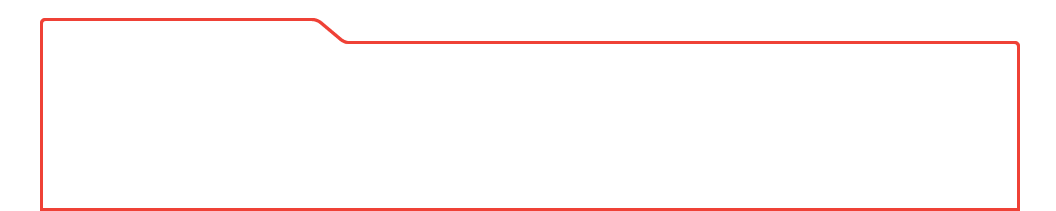
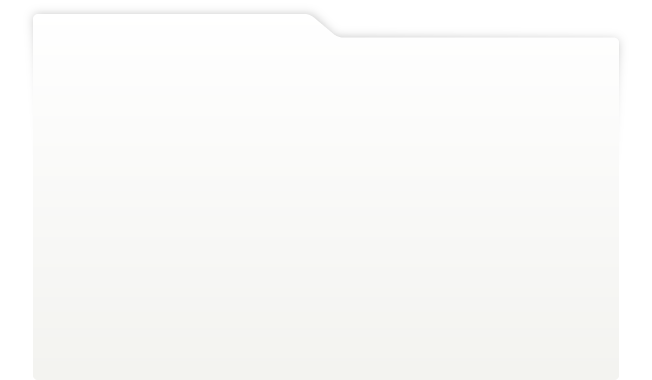
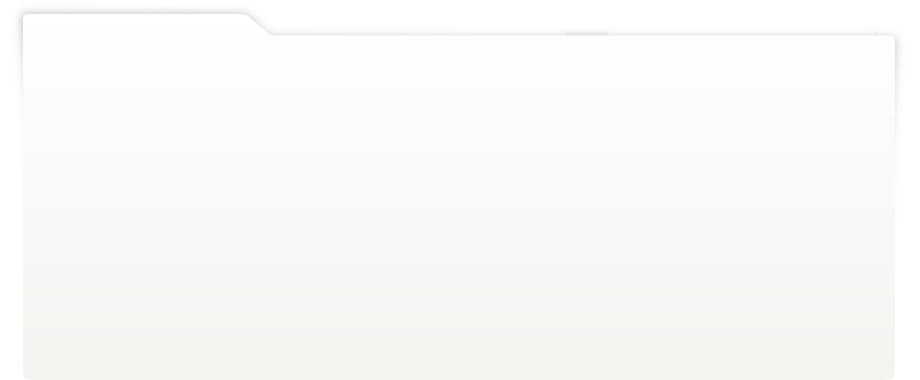
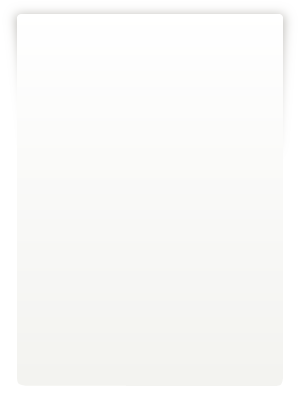
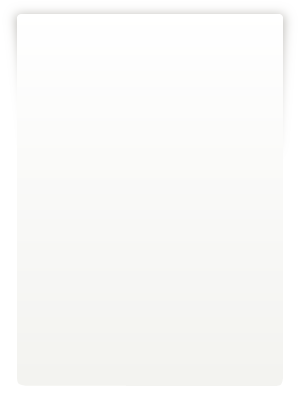
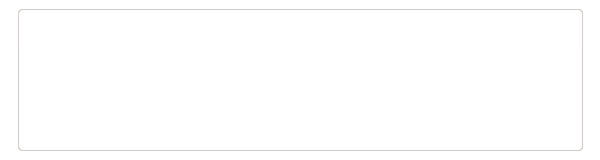
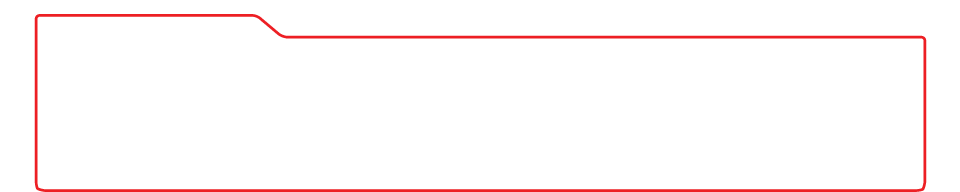
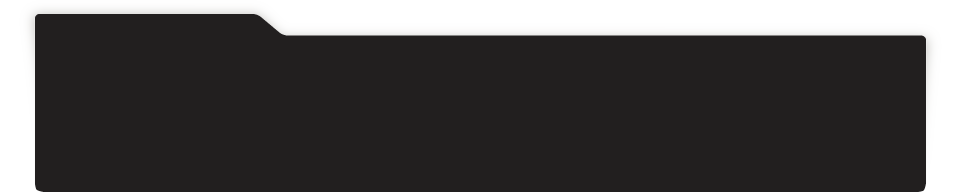
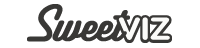
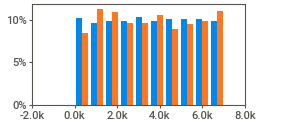
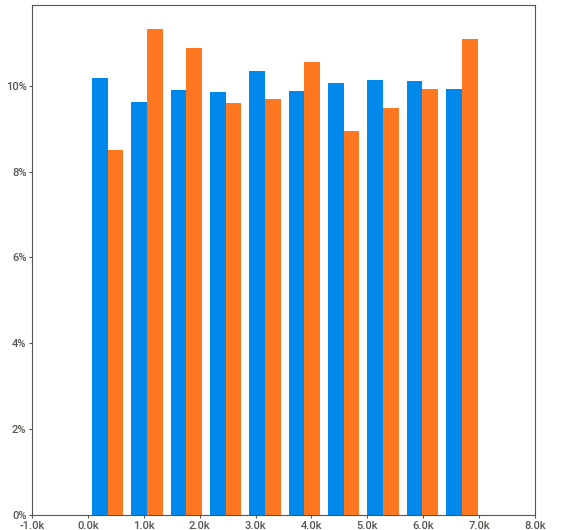
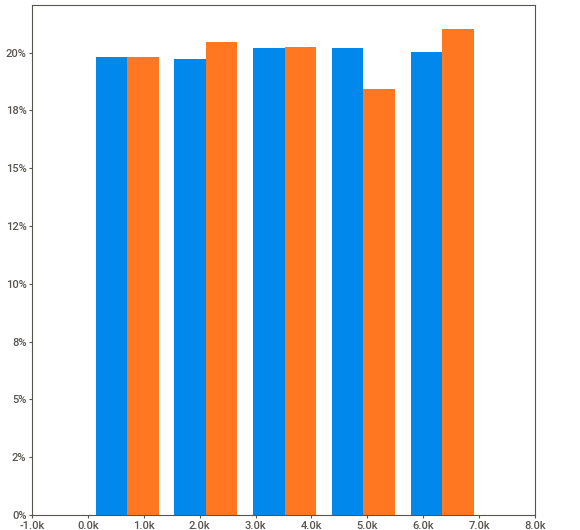
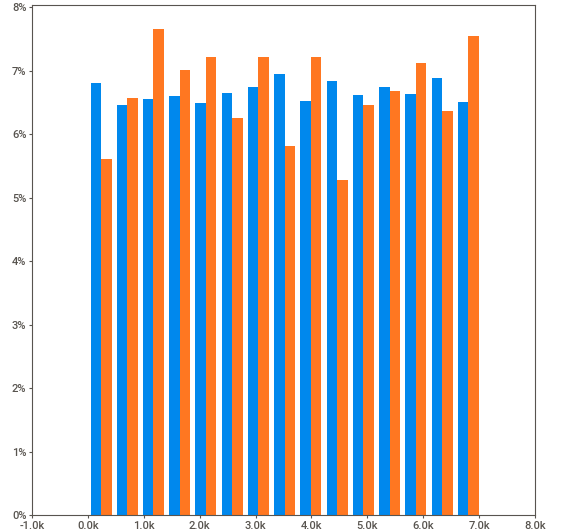
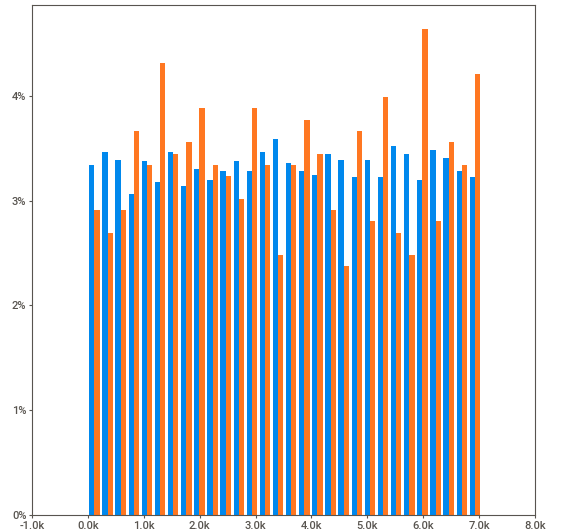
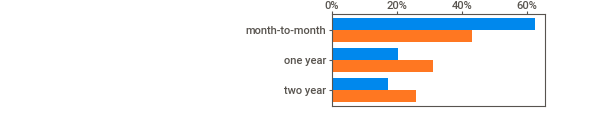
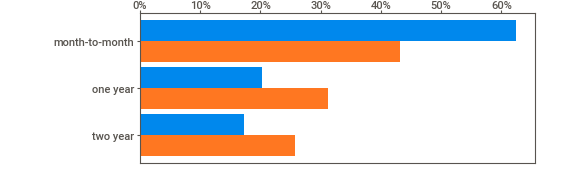
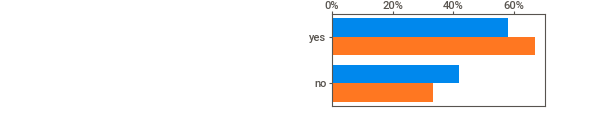
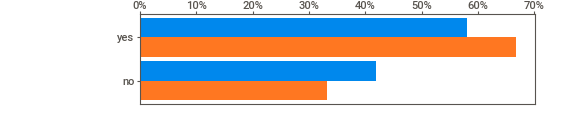
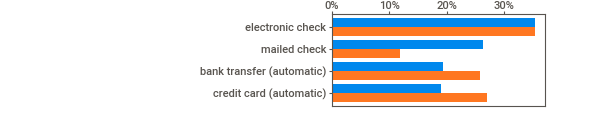
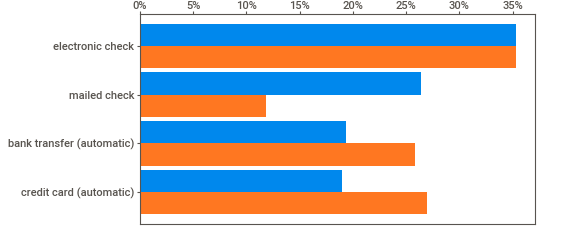
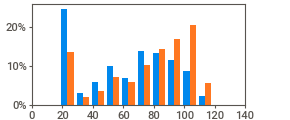
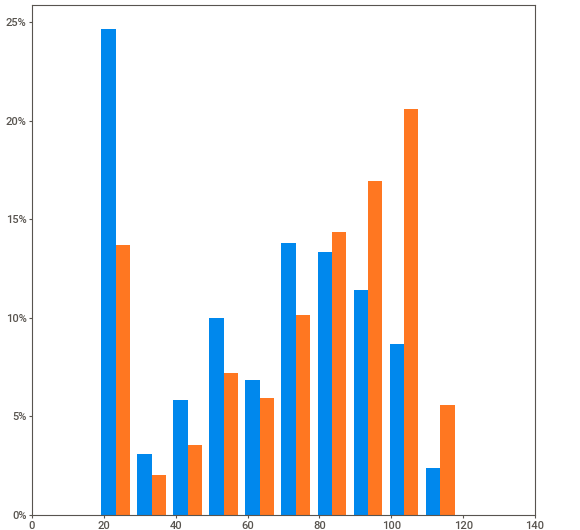
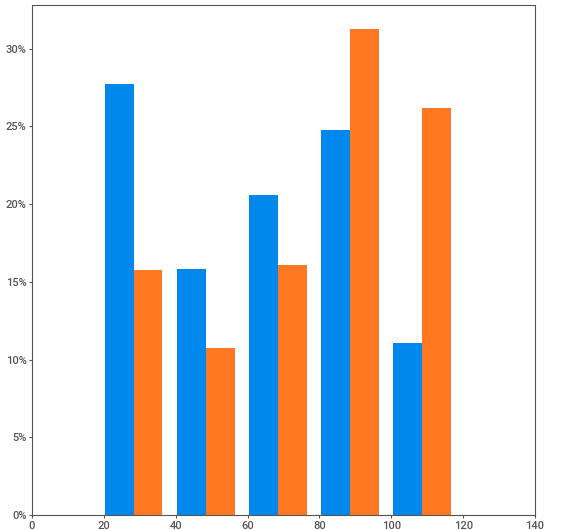
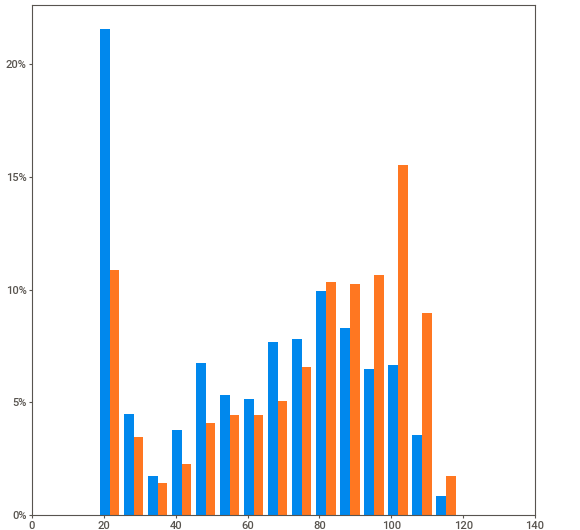
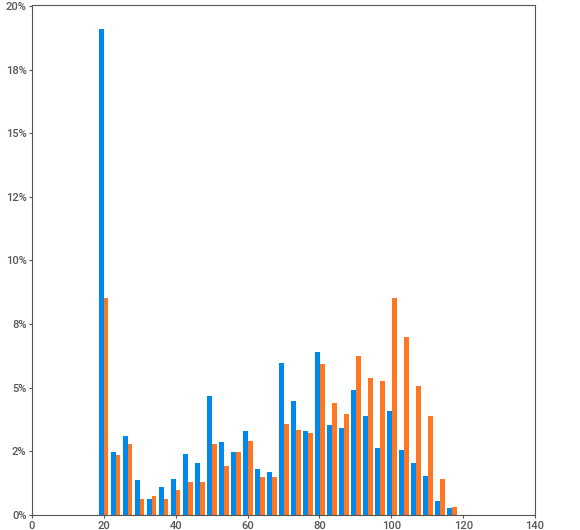
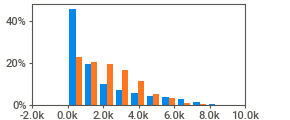
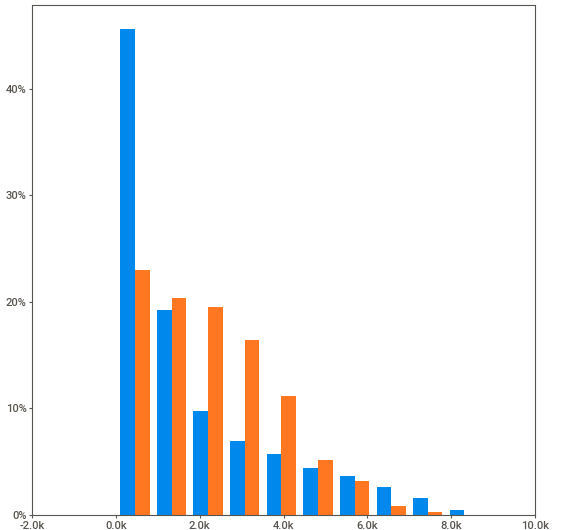
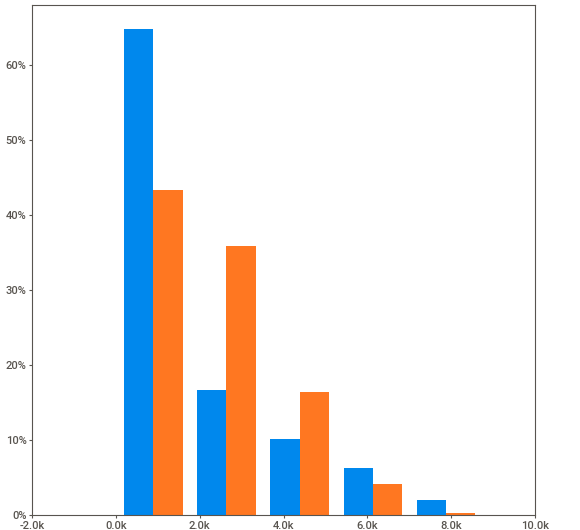
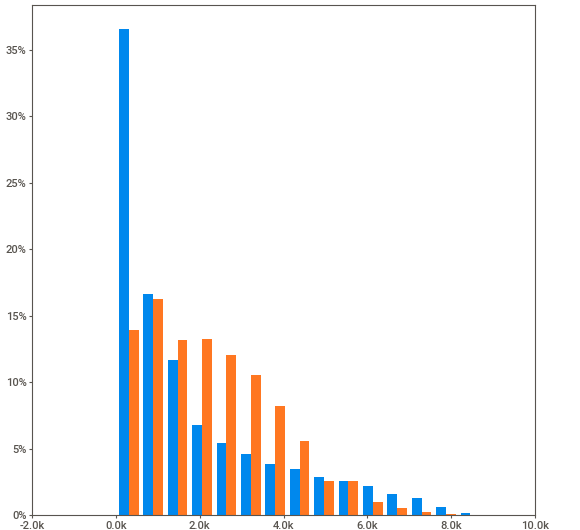
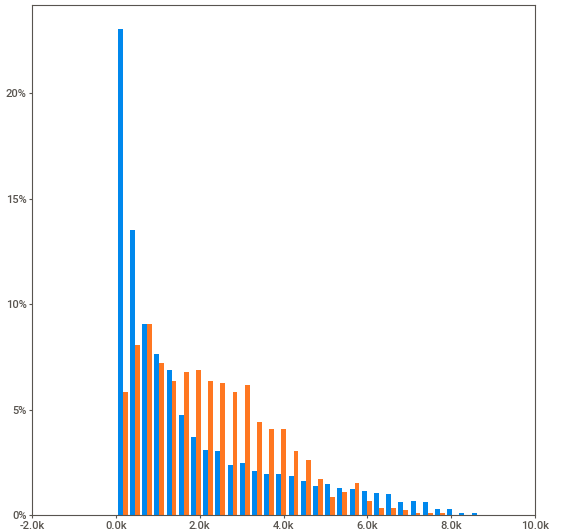
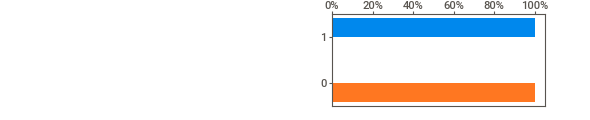
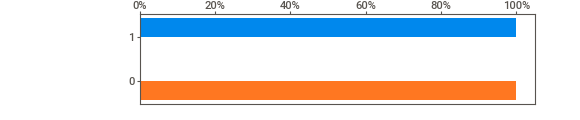
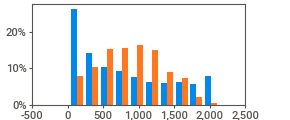
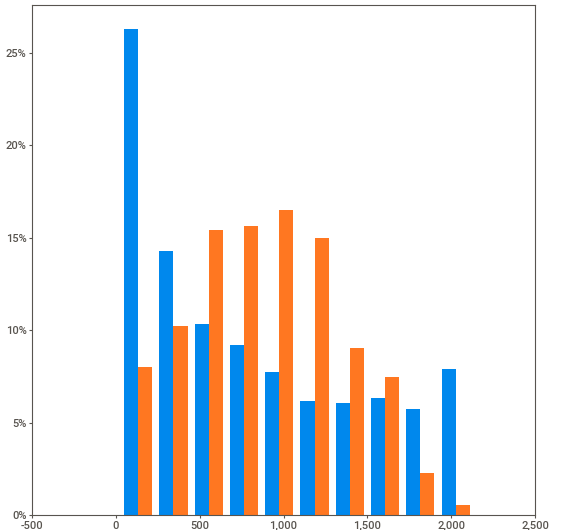
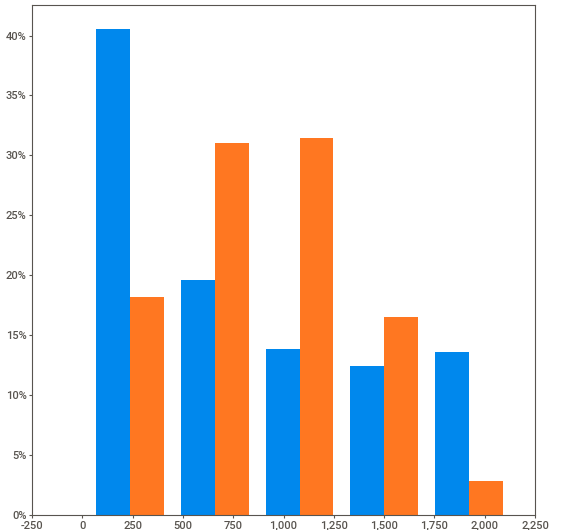
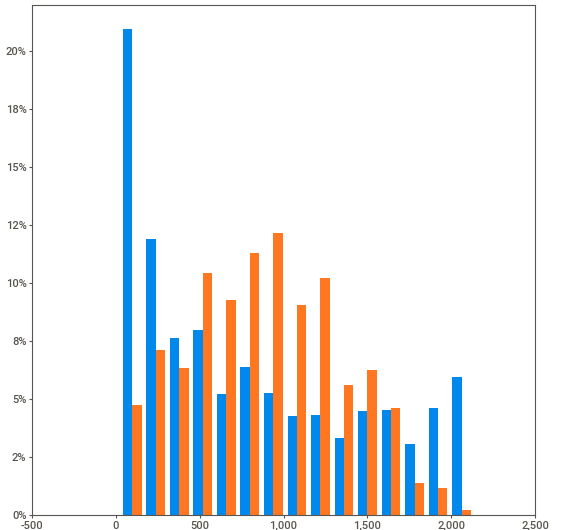
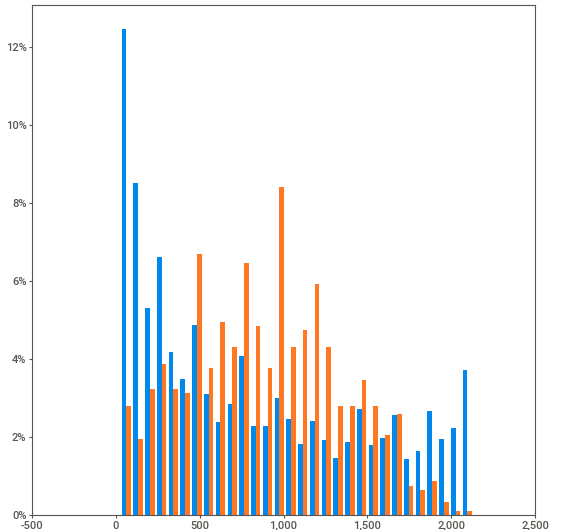
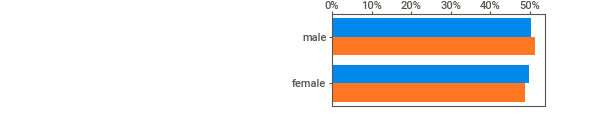
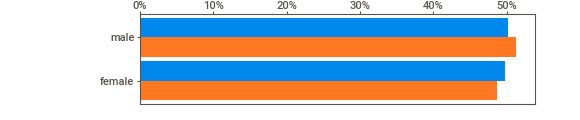
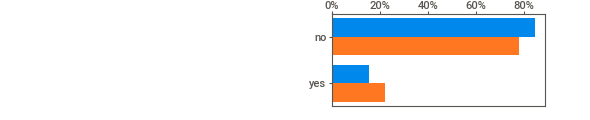
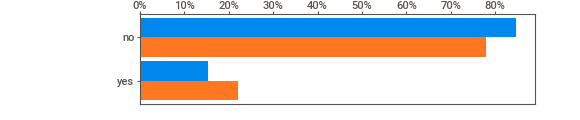
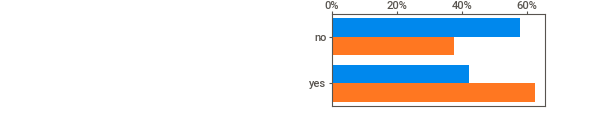
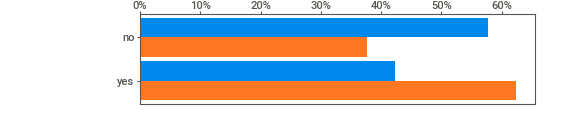
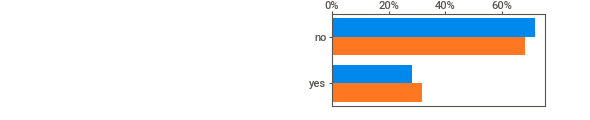
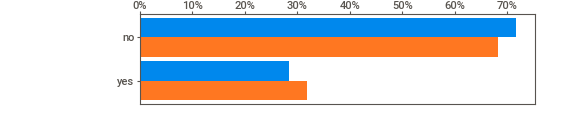
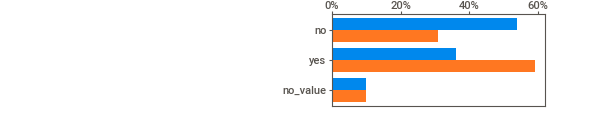
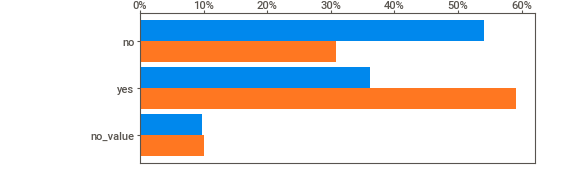
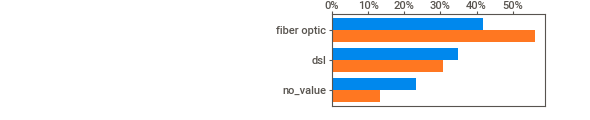
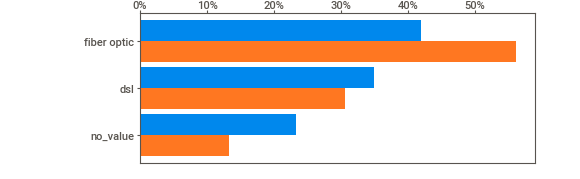
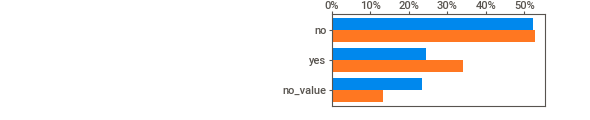
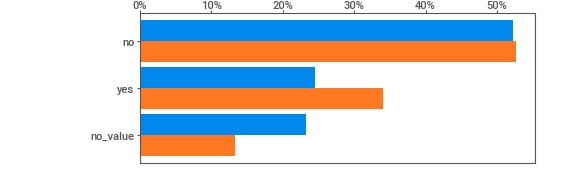
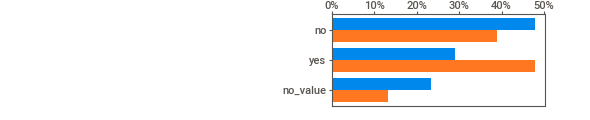
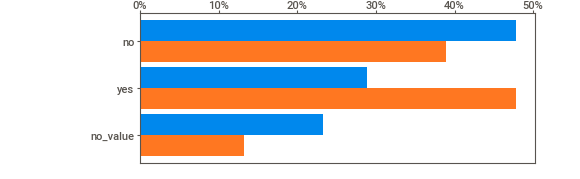
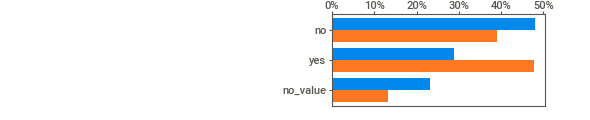
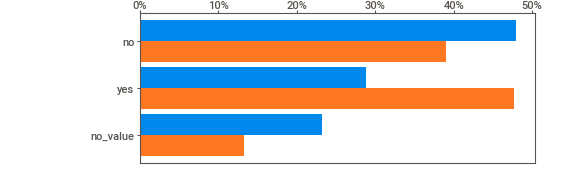
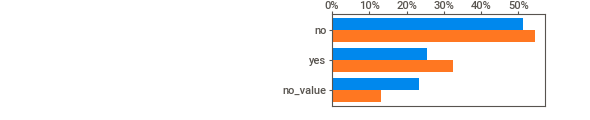
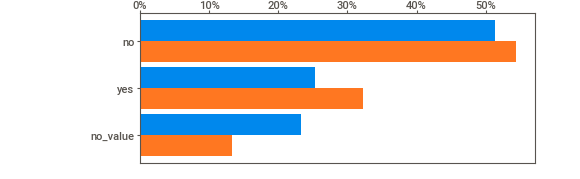
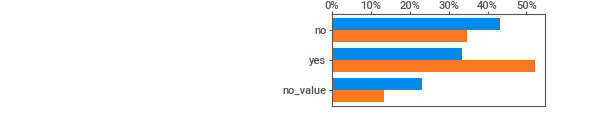
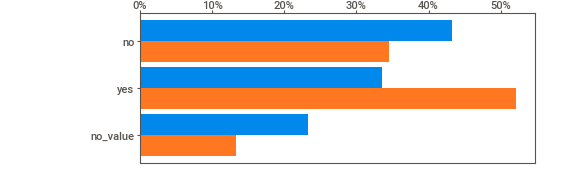
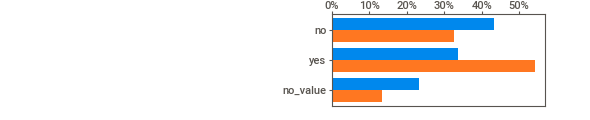
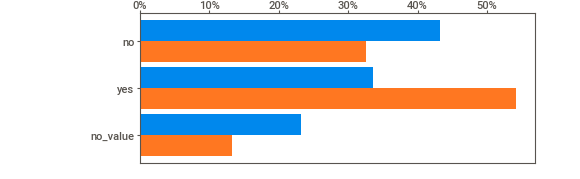
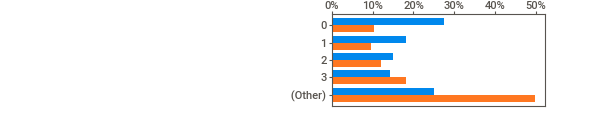
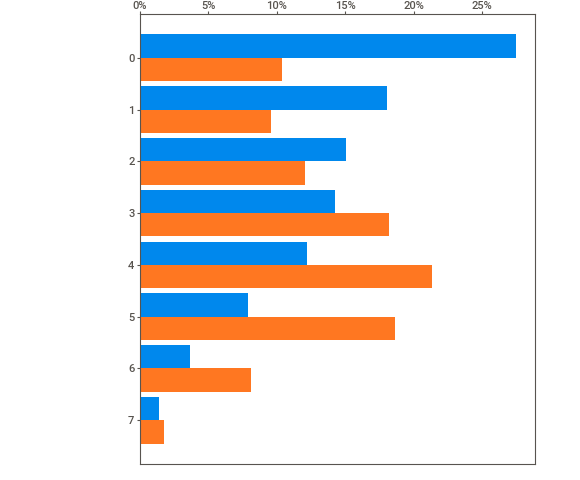
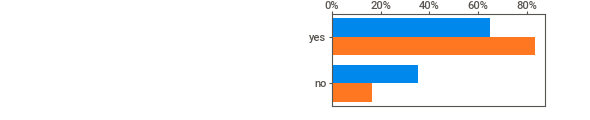
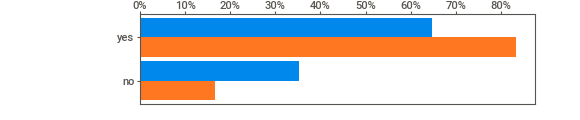
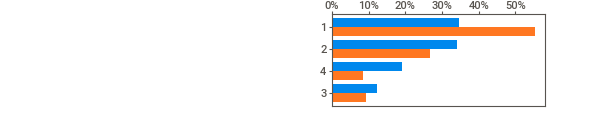
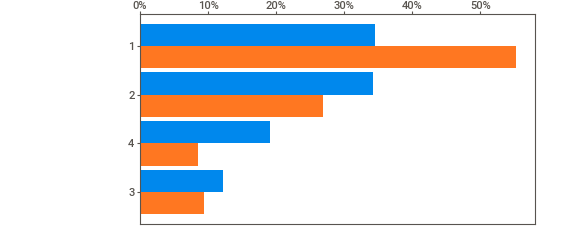
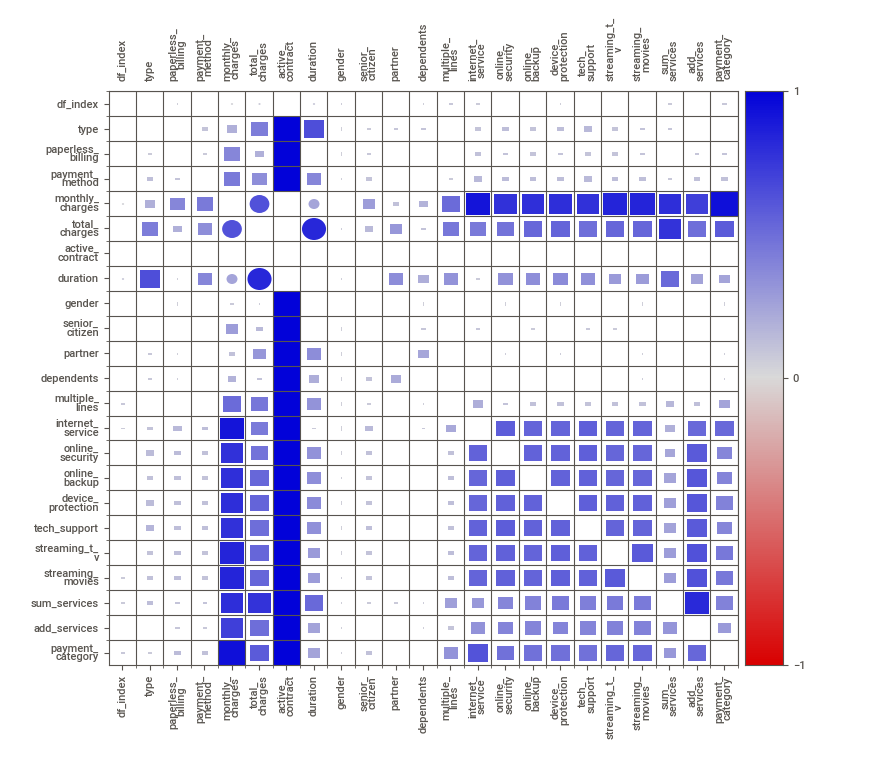
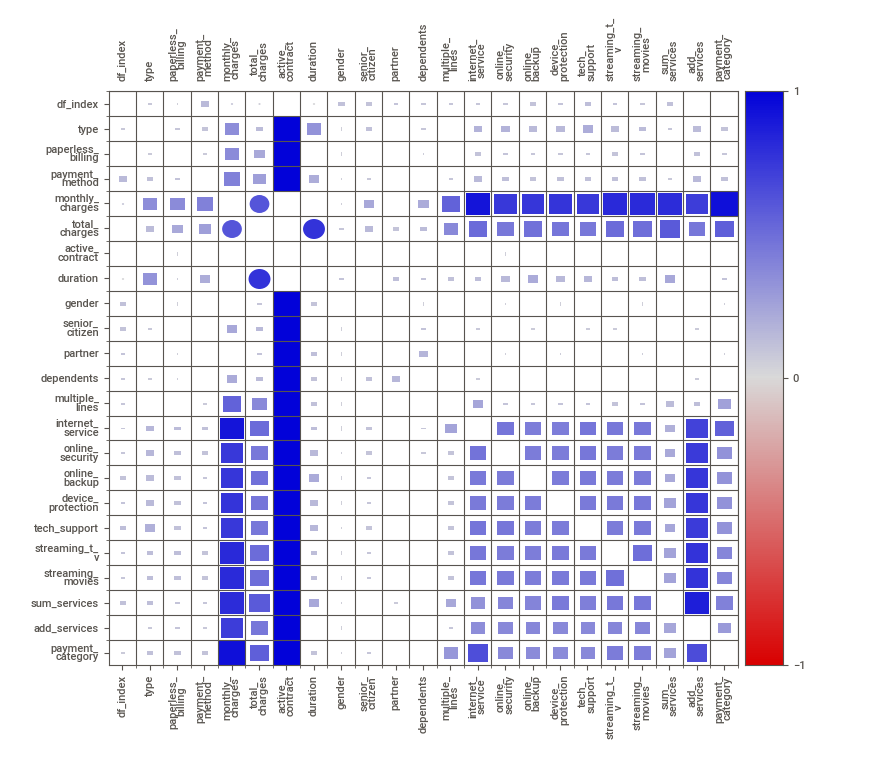

In [ ]:
comparison.show_notebook()

Выводы по результатам графиков из полученного отчета:  

1. К оттоку менее склонны пользователи с долгосрочными контрактами.  
2. Оплачивающие услуги кредитными картами и автопереводами пклиенты склонны к оттоку. Что-то пошло не так в наш век кибернетики, о чем нужно сообщить ТелеДому. Возможно, у низ проблема в этом направлении: неудобная форма оплаты на сайте и прочее.
3. Пользователи, платящие за услуги оператора больше 80 у.е. в месяц, показывают самый большой отток из всех категорий (их 4).
4. Лояльность к оператору связи растет по мере увеличения срока пользования сервисом. Пользователи привыкают не склонны уходить, есть смысл удерживать не совсем новых клиентов, а клиентов со "стажем" от 1 до 5 лет.
5. Пользователи в браке склонны к оттоку.
6. Пенсионеров среди клиентов не много и они склонны к оттоку.
7. Пользователи с подключенными доп.услугами склонны утекать.

**Изучим корреляцию всех имеющихся признаков на тепловой карте при помощи библиотеки Phik**

In [ ]:
phik_overview = df.drop(columns='customer_id').phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['index', 'monthly_charges', 'total_charges', 'active_contract', 'duration', 'sum_services', 'payment_category']


,index,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,duration,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,sum_services,add_services,payment_category
index,1.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.03,0.01,0.02,0.00,0.00,0.05,0.00,0.00
type,0.00,1.00,0.12,0.26,0.38,0.41,0.08,0.59,0.00,0.09,...,0.55,0.62,0.57,0.62,0.66,0.55,0.56,0.39,0.07,0.16
paperless_billing,0.00,0.12,1.00,0.38,0.47,0.20,0.09,0.02,0.01,0.24,...,0.23,0.21,0.20,0.20,0.20,0.21,0.20,0.35,0.38,0.51
payment_method,0.03,0.26,0.38,1.00,0.40,0.31,0.19,0.32,0.00,0.31,...,0.33,0.31,0.29,0.29,0.31,0.29,0.29,0.44,0.45,0.54
monthly_charges,0.00,0.38,0.47,0.40,1.00,0.68,0.24,0.34,0.01,0.32,...,0.92,0.81,0.81,0.82,0.81,0.86,0.86,0.79,0.98,0.93
total_charges,0.00,0.41,0.20,0.31,0.68,1.00,0.28,0.84,0.00,0.15,...,0.48,0.49,0.52,0.53,0.50,0.54,0.53,0.60,0.67,0.53
active_contract,0.00,0.08,0.09,0.19,0.24,0.28,1.00,0.33,0.00,0.10,...,0.07,0.06,0.09,0.09,0.05,0.08,0.09,0.29,0.22,0.23
duration,0.00,0.59,0.02,0.32,0.34,0.84,0.33,1.00,0.00,0.07,...,0.05,0.30,0.33,0.33,0.31,0.27,0.27,0.38,0.30,0.19
gender,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01
senior_citizen,0.00,0.09,0.24,0.31,0.32,0.15,0.10,0.07,0.00,1.00,...,0.17,0.13,0.11,0.11,0.14,0.12,0.12,0.18,0.20,0.32


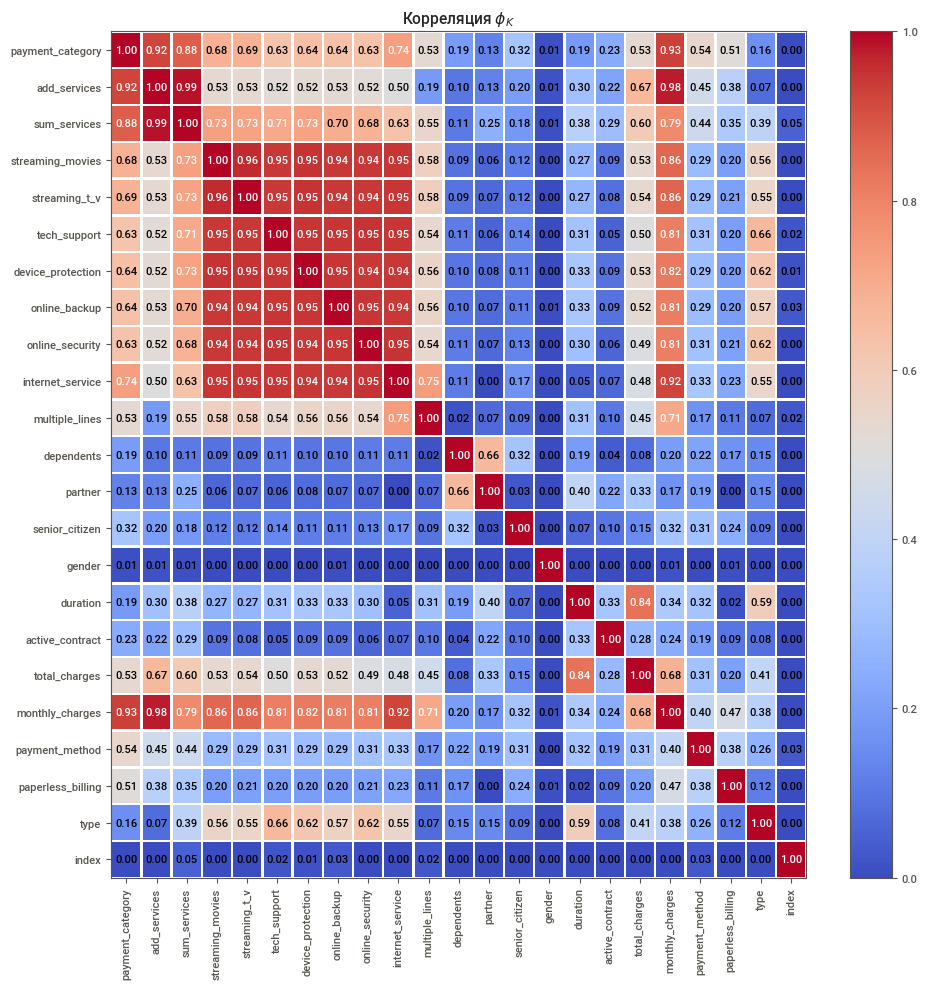

In [ ]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(10, 10))
plt.tight_layout()

interval columns not set, guessing: ['index', 'monthly_charges', 'total_charges', 'active_contract', 'duration', 'sum_services', 'payment_category']


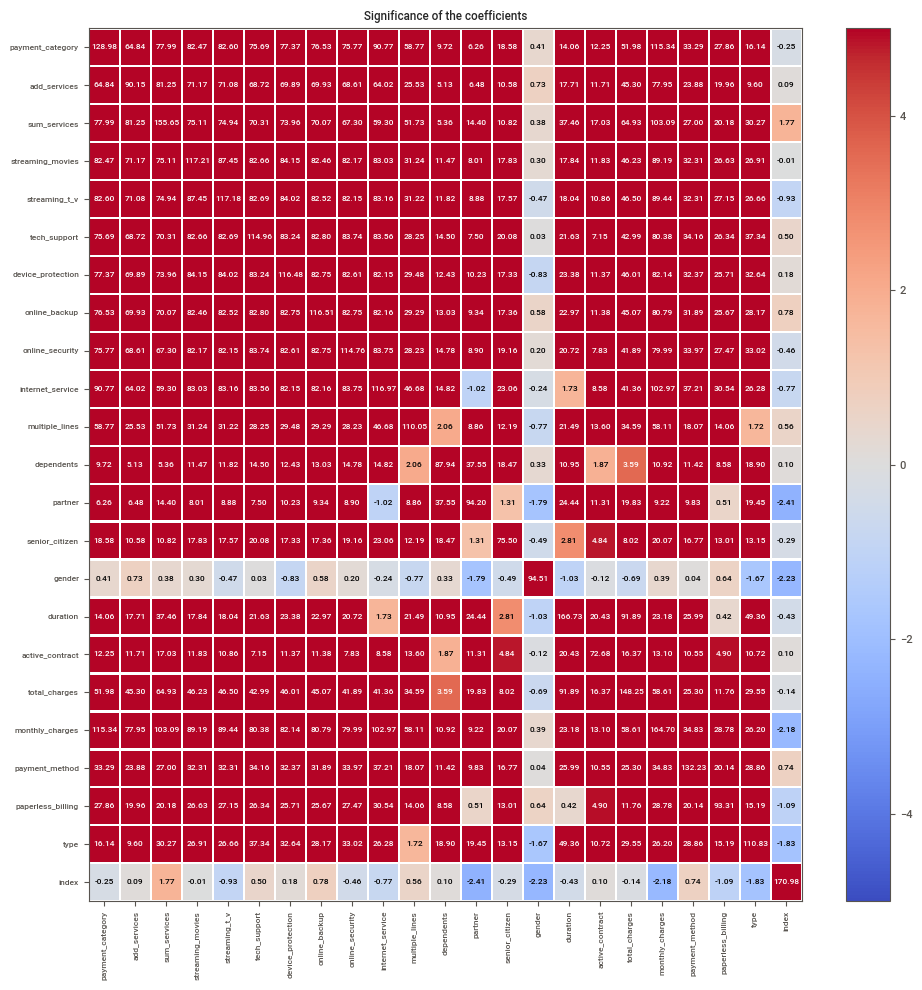

In [ ]:
significance_overview = df.drop(columns='customer_id').significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, color_map="coolwarm",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.6, figsize=(10, 10))
plt.tight_layout()

Признаки, отвечащие за дополнительные услуги, сильно скоррелированы друг с другом и слабо коррелируют с таргетом. Сильная корреляция может говорить о мультиколлинеарности между ними, что может повлиять на предсказания модели. Эти признаки после анализа будут удалены.  
  
Признаки пола, пенсионного возраста и наличия детей имют очень низкую корреляцию,удалим их.




К удалению:  
streaming_movies   
streaming_t_v       
tech_support        
device_protection    
online_backup        
online_security      
internet_service     
multiple_lines             
dependents                 
total_charges                
gender
type                  

,customer_id,type,paperless_billing,payment_method,monthly_charges,active_contract,duration,senior_citizen,partner,sum_services,payment_category
4472,4501-uykbc,one year,yes,credit card (automatic),69.10,1,1401,yes,no,4,2
1667,6908-vvyhm,month-to-month,yes,electronic check,90.65,1,1979,no,yes,3,1
5826,9286-dojgf,month-to-month,yes,bank transfer (automatic),74.95,0,911,yes,yes,1,2


interval columns not set, guessing: ['monthly_charges', 'active_contract', 'duration', 'sum_services', 'payment_category']


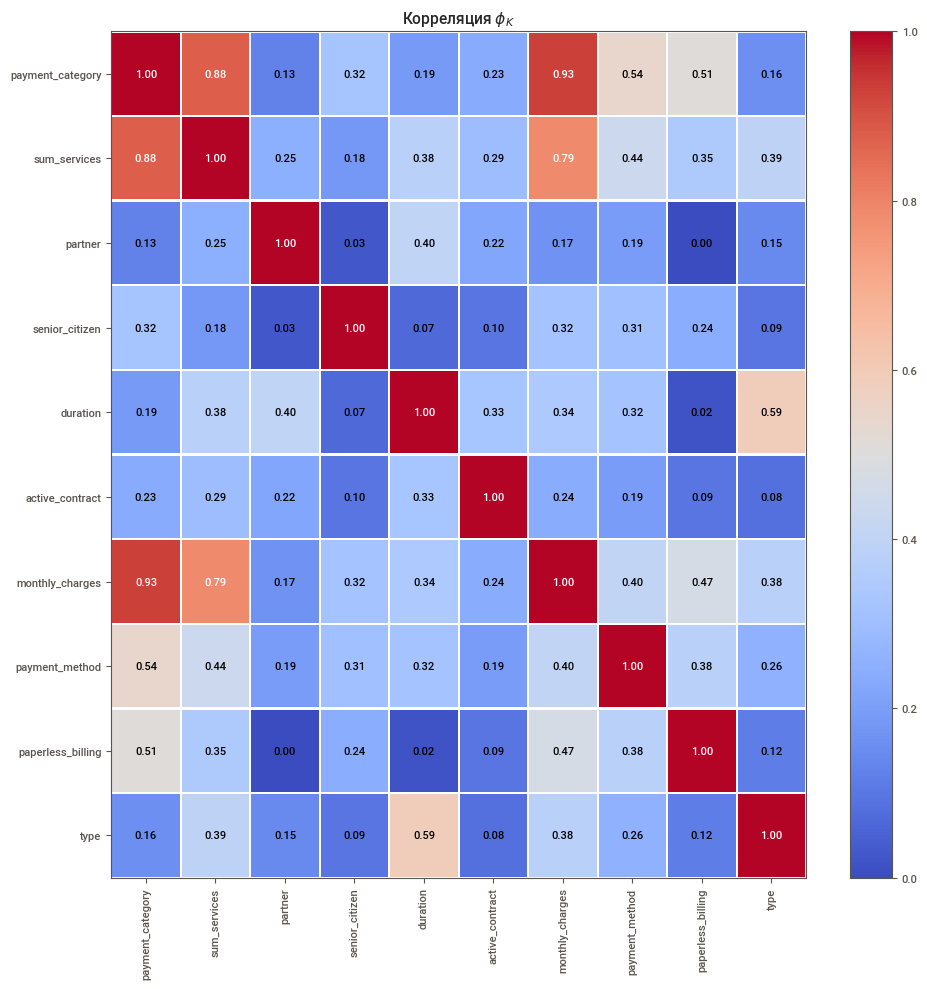

In [ ]:
new_df = df.copy()
new_df = new_df.drop(columns=['gender', 'total_charges', 'add_services', 'index',\
                              'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_movies', \
                              'streaming_t_v', 'dependents', 'multiple_lines', 'internet_service'])
display(new_df.sample(3))

phik_overview = new_df.drop(columns='customer_id').phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(10, 10))
plt.tight_layout()

# Подготовка данных
Выполните подготовку данных для обучения модели. Разделите данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей.

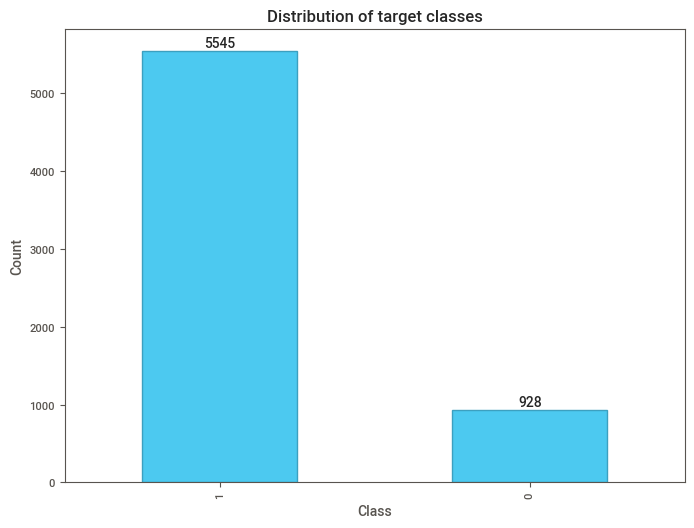

In [ ]:
plt.figure(figsize=(8,6))
counts = new_df['active_contract'].value_counts()
counts.plot(kind='bar', color='#4CC9F0', ec='#3ca0c0')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of target classes')

# добавление подписей
for i, value in enumerate(counts):
    plt.text(i, value + 50, str(value), ha = 'center')

plt.show()

Видим дисбаланс классов, разделение на тренировочную и тестовую выборку будем производить с применением стратификации по тагрету, хотя ROC_AUC не чувствительная к дисбалансу.

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6473 entries, 0 to 6472
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        6473 non-null   object 
 1   type               6473 non-null   object 
 2   paperless_billing  6473 non-null   object 
 3   payment_method     6473 non-null   object 
 4   monthly_charges    6473 non-null   float64
 5   active_contract    6473 non-null   int64  
 6   duration           6473 non-null   int64  
 7   senior_citizen     6473 non-null   object 
 8   partner            6473 non-null   object 
 9   sum_services       6473 non-null   int64  
 10  payment_category   6473 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 606.8+ KB


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    new_df.drop(columns=['customer_id', 'active_contract']), new_df['active_contract'], test_size=.25,
    random_state=RANDOM_STATE, stratify=new_df['active_contract'])

print(f'размеры:\n{features_train.shape=}   {target_train.shape=}\n{features_test=}   {target_test.shape=}\n')

размеры:
features_train.shape=(4854, 9)   target_train.shape=(4854,)
features_test=                type paperless_billing             payment_method  \
3117  month-to-month                no    credit card (automatic)   
1078        one year               yes  bank transfer (automatic)   
4299  month-to-month               yes    credit card (automatic)   
3499  month-to-month                no           electronic check   
1411        two year               yes  bank transfer (automatic)   
...              ...               ...                        ...   
798   month-to-month                no           electronic check   
2748        two year                no               mailed check   
5248        two year                no  bank transfer (automatic)   
1584        one year                no  bank transfer (automatic)   
4764        two year               yes               mailed check   

      monthly_charges  duration senior_citizen partner  sum_services  \
3117            

In [ ]:
""" Функция для обучения модели машинного обучения с использованием
    кросс-валидации и поиска оптимальных гиперпараметров """
def train_model(X_train, y_train, model, param_grid, random_state=RANDOM_STATE):

    # Cписок числовых признаков
    num_features = X_train.select_dtypes(include=['number']).columns

    # Cписок категориальных признаков
    cat_features = X_train.select_dtypes(include=['object']).columns

    # KFold для кроссвалидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Кодировщик для категориальных признаков
    preprocessor_cat = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # Кодировщик для числовых признаков
    preprocessor_num = Pipeline(steps=[
        ('scaler', RobustScaler())
    ])

    # Создание трансформера
    preprocessor = ColumnTransformer(transformers=[
        ('categorical_encoder', preprocessor_cat, cat_features),
        ('numeric_encoder', preprocessor_num, num_features)
    ])

    # Pipeline с кодированием признаков и моделью
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Объект RandomizedSearchCV для подбора гиперпараметров
    random_search = RandomizedSearchCV(pipeline, param_grid, scoring='roc_auc',
                                       cv=skf, n_jobs=-1, n_iter=20, random_state=RANDOM_STATE)

    # Обучение RandomizedSearchCV на обучающей выборке
    random_search.fit(X_train, y_train)

    # Извлечение лучшей модели и ее гиперпараметров
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    model_name = random_search.best_estimator_.named_steps['model'].__class__.__name__

    # Выводим название модели, лучшие гиперпараметры и метрики

    result = {'Mодель': model_name,
              'Гиперпараметры': best_params,
              'ROC-AUC на трейне': round(random_search.best_score_, 2)}
    # Возвращаем лучшую модель и метрики
    return result, best_model

Для обучения возьмем следующие модели:   

- LogisticRegression  
- RandomForestClassifier  
- CatBoostClassifier  
- XGBClassifier  

Подберем лучшую модель с оптимальными гиперпараметрами и получим лучшую метрику ROC-AUC на кросс-валидации.



Создадим таблицу с результатами обучения моделей:  

In [ ]:
result_table = pd.DataFrame(columns=['Mодель', 'Гиперпараметры', 'ROC-AUC на трейне'])

**LogisticRegression**  

In [ ]:
%%time

# Объект модели
model = LogisticRegression()

# Параметры сетки для подбора гиперпараметров
param_grid = {
            'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
            'model__C': np.logspace(-3, 3, 20),
            'model__penalty': ["l1", "l2"]
}

# Вызов функции train_model
lr_result, lr_model = train_model(features_train, target_train, LogisticRegression, param_grid)
# Вывод результатов
display(lr_result)
# Добавление результаты в сводную таблицу
result_table = result_table.append(lr_result, ignore_index=True)

{'Mодель': 'LogisticRegression',
 'Гиперпараметры': {'model__penalty': 'l1',
  'model__C': 0.6951927961775606,
  'model': LogisticRegression(C=0.6951927961775606, penalty='l1', random_state=271123,
                     solver='liblinear')},
 'ROC-AUC на трейне': 0.73}

CPU times: user 10.4 s, sys: 9.28 s, total: 19.7 s
Wall time: 20 s


**Random Forest**

In [ ]:
%%time
# Объект модели
model = RandomForestClassifier()

# Параметры сетки для подбора гиперпараметров
param_grid = {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': range(10, 101, 30),
        'model__max_depth': range(1, 6)
}

# Вызов функции train_model
rf_result, rf_model = train_model(features_train, target_train, RandomForestClassifier, param_grid)
# Вывод результатов
display(rf_result)
# Добавление результатов в сводную таблицу
result_table = result_table.append(rf_result, ignore_index=True)

{'Mодель': 'RandomForestClassifier',
 'Гиперпараметры': {'model__n_estimators': 100,
  'model__max_depth': 5,
  'model': RandomForestClassifier(max_depth=5, random_state=271123)},
 'ROC-AUC на трейне': 0.79}

CPU times: user 13.6 s, sys: 68.3 ms, total: 13.7 s
Wall time: 13.7 s


**CatBoostClassifier**

In [ ]:
%%time
# Объект модели
model = CatBoostClassifier()

# Параметры сетки для подбора гиперпараметров
param_grid = {
        'model': [CatBoostClassifier(loss_function='Logloss',
                                     eval_metric='AUC',
                                     task_type="CPU",
                                     verbose=False,
                                     random_seed=RANDOM_STATE)],
        'model__learning_rate': [0.01, 0.03, 0.001],
        'model__depth': range(1, 6)
    }

# Вызов функции train_model
cb_result, cb_model = train_model(features_train, target_train, CatBoostClassifier, param_grid)
# Вывод результатов
display(cb_result)
# Добавление результатов в сводную таблицу
result_table = result_table.append(cb_result, ignore_index=True)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'Mодель': 'CatBoostClassifier',
 'Гиперпараметры': {'model__learning_rate': 0.03,
  'model__depth': 5,
  'model': <catboost.core.CatBoostClassifier at 0x7f9667611f10>},
 'ROC-AUC на трейне': 0.89}

CPU times: user 1min 15s, sys: 4.35 s, total: 1min 19s
Wall time: 2min 5s


**XGBClassifier**

In [ ]:
%%time
# Объект модели
model = XGBClassifier()

# Параметры сетки для подбора гиперпараметров
param_grid = {
        'model': [XGBClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 300, 500],
        'model__learning_rate': [0.01, 0.1, 0.5],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__gamma': [0, 1, 5]
    }

# Вызов функции train_model
xgbc_result, xgbc_model = train_model(features_train, target_train, XGBClassifier, param_grid)
# Вывод результатов
display(xgbc_result)
# Добавление результаты в сводную таблицу
result_table = result_table.append(xgbc_result, ignore_index=True)

[11:18:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:18:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:18:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:18:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:24:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Mодель': 'XGBClassifier',
 'Гиперпараметры': {'model__subsample': 1.0,
  'model__n_estimators': 300,
  'model__max_depth': 5,
  'model__learning_rate': 0.1,
  'model__gamma': 0,
  'model__colsample_bytree': 0.8,
  'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=0.8,
                enable_categorical=False, gamma=0, gpu_id=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.1, max_delta_step=None, max_depth=5,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=300, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=271123, reg_alpha=None,
                reg_lambda=None, scale_pos_weight=None, subsample=1.0,
                tree_method=None, validate_parameters=None, verbosity=None)},
 'ROC-AUC на трейне': 0.88}

CPU times: user 18min 46s, sys: 9.53 s, total: 18min 55s
Wall time: 19min 5s


# Выбор лучшей модели

Посмотим на сводную таблицу:

In [ ]:
result_table.sort_values('ROC-AUC на трейне', ascending=False)

,Mодель,Гиперпараметры,ROC-AUC на трейне
2,CatBoostClassifier,"{'model__learning_rate': 0.03, 'model__depth':...",0.89
3,XGBClassifier,"{'model__subsample': 1.0, 'model__n_estimators...",0.88
1,RandomForestClassifier,"{'model__n_estimators': 100, 'model__max_depth...",0.79
0,LogisticRegression,"{'model__penalty': 'l1', 'model__C': 0.6951927...",0.73


Исходя из сводной таблицы, лучшей моделью можем признать CatBoostClassifier с метрикой ROC-AUC 0.91  

**Предварительный вывод**  

Были выбраны 4 модели: LogisticRegression, RandomForestClassifier и 2 модели на основе градиентного бустинга: CatBoostClassifier и XGBClassifier.  
Для подбора лучших гиперпараметров на кросс-валидации мы при помощи RandomizedSearchCV обработали каждую модель по отдельности и вывели результат в сводную таблицу.

## Тестирование модели

In [ ]:
def test_model(model, features_test):

    # Получение имени модели
    model_name = model.named_steps['model'].__class__.__name__

    # Предсказание на тестовой выборке
    predictions = model.predict(features_test)
    probabilities = model.predict_proba(features_test)[:, 1]

    # Вычисление ROC-AUC
    roc_auc = roc_auc_score(target_test, probabilities)

    # Построение матрицы ошибок
    cm = confusion_matrix(target_test, predictions)

    # Вывод результатов
    print("Модель:", model_name)
    print("ROC-AUC на тестовой выборке:", round(roc_auc, 4))

    # Создание графиков на одной строке
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Построение матрицы ошибок
    sns.heatmap(cm, annot=True, cmap='coolwarm', ax=axes[0], fmt='d')
    axes[0].set_title(f'Матрица ошибок\n[TN, FP]\n[FN, TP]')
    axes[0].set_xlabel('Предсказанные классы')
    axes[0].set_ylabel('Реальные классы')

    # Построение ROC-кривой
    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    sns.lineplot(x=fpr, y=tpr, label='ROC-кривая (S = {:.2f})'.format(roc_auc), ax=axes[1])
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', ax=axes[1])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC-Кривая')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

Модель: CatBoostClassifier
ROC-AUC на тестовой выборке: 0.9096


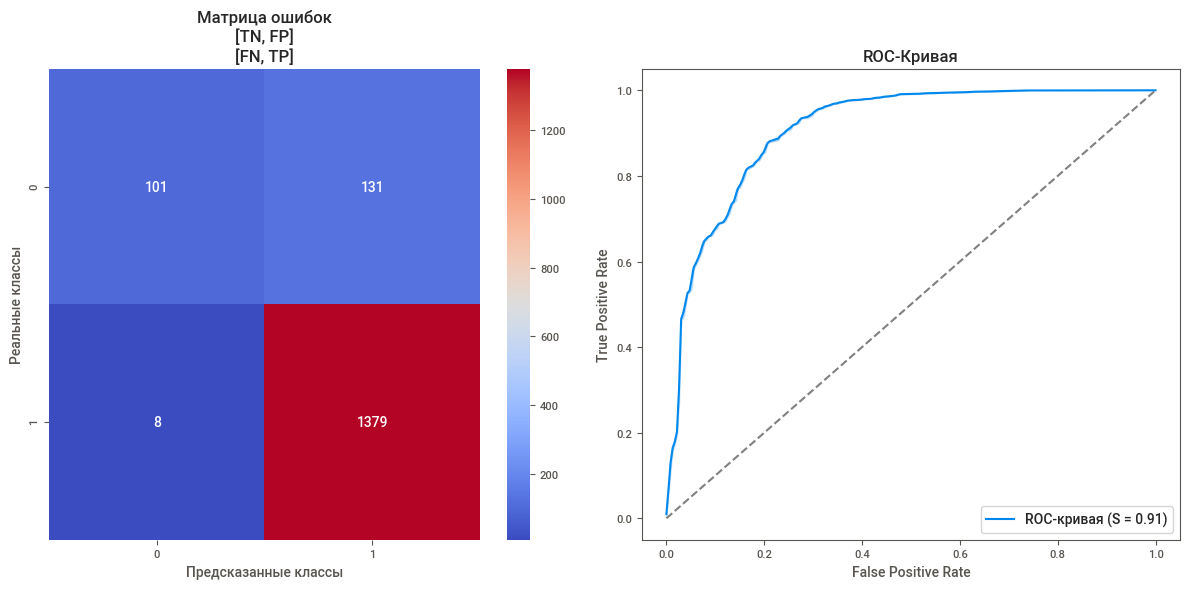

In [ ]:
test_model(cb_model, features_test)

Лучшая модель - CatBoostClassifier показала ROC-AUC на тестовой выборке: 0.9096.  
Резмер тестовой выборки - 1619    
Модель верно предсказала оставшихся клиентов (класс 1) - 1379 раза    
Модель ошиблась в предсказании оставшихся клиентов (класс 1) - 131 раз   
Модель верно предсказала ушедших клиентов (класс 0) - 101 раза    
Модель ошиблась в предсказании оставшихся клиентов (класс 0) - 8 раз.  

Исследуем важность признаков модели

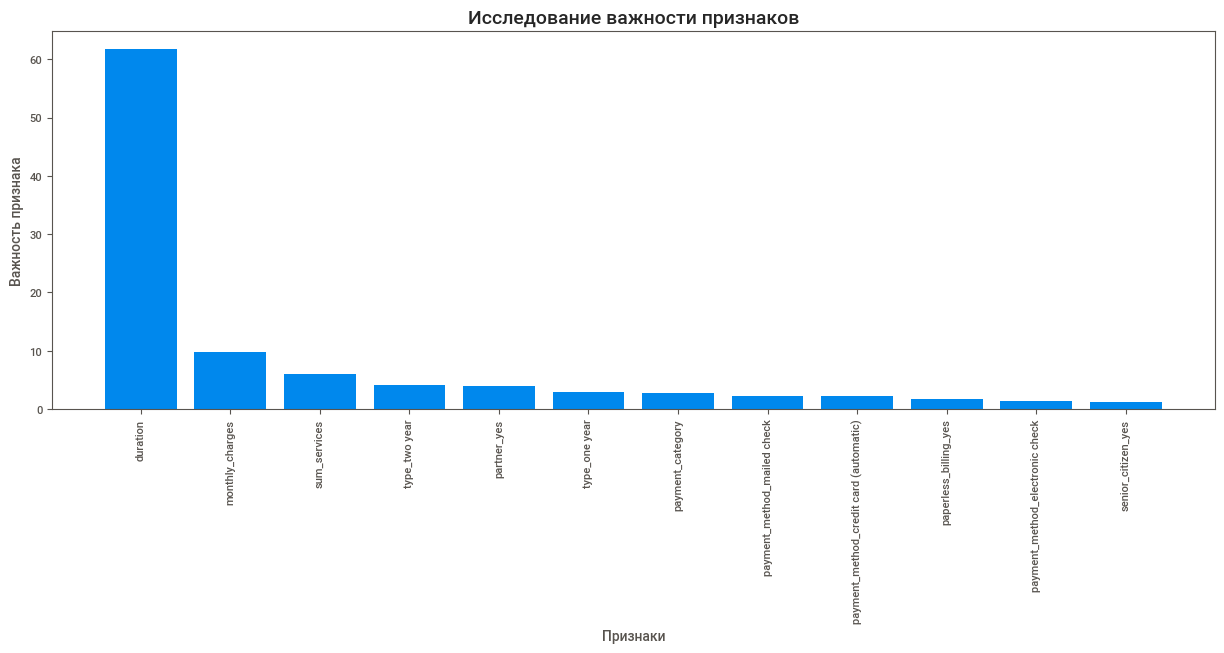

,Важность признака
Признак,
duration,61.687320
monthly_charges,9.779602
sum_services,6.085007
type_two year,4.075599
partner_yes,3.982434
type_one year,2.972281
payment_category,2.788499
payment_method_mailed check,2.223984
payment_method_credit card (automatic),2.174947


In [ ]:
model = cb_model.named_steps['model']

# Проверка, поддерживает ли модель расчет важности признаков
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = cb_model.named_steps['preprocessor'].get_feature_names_out()

        # Удаление названий кодировщика из начала признаков
    feature_names = [name.split("__")[1] for name in feature_names]

    importances_df = pd.DataFrame(importances, index=feature_names, columns=['Важность признака'])
    importances_df = importances_df.sort_values(by='Важность признака', ascending=False)

        # Изменение названия столбца индекса
    importances_df.index.name = 'Признак'

        # Построение графика важности признаков
    plt.figure(figsize=(15, 5))
    plt.title('Исследование важности признаков', fontsize=14)
    plt.bar(importances_df.index, importances_df['Важность признака'])
    plt.xticks(rotation=90)
    plt.xlabel('Признаки')
    plt.ylabel('Важность признака')
    plt.show()

    display(importances_df)


Из графика и сводной таблицы можем видеть, что самыми важными оказались признаки: duration(длительность контракта в днях), monthly_charges(расходы за месяц) и sum_services(суммарное количество подключенных услуг).

**Проверка модели на адекватность моделью DummyClassifier**  
 Проверим, что модель выдает не просто набор случайно подобранных данных и справляется с задачей лучше, чем если бы мы предсказывали случайным образом.

In [ ]:
dummy_clf = DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(features_train, target_train)
probabilities_test_d = dummy_clf.predict_proba(features_test)
roc_auc_dummy_test = roc_auc_score(target_test, probabilities_test_d[:, 1])
print(f'DummyClassifier(constant) roc_auc_score: {roc_auc_dummy_test}')

DummyClassifier(constant) roc_auc_score: 0.5


Наша модель адекватна

## Общий вывод и рекомендации заказчику

**Вывод**  
В ходе проекта мы реализовали следующие шаги:  

1. Провели первичный анализ данных:  
 -загрузили и описали данные  
 -провели предобработку данны  
 -объединили 4 датафрейма в один  
 -обработали пропущенные значения  
 -сгенерировали целевой признак для машинного обучения.  
2. Провели исследовательский анализ данных:  
 -исследовали признаки, выделили незначимые и малозначимые признаки для машинного обучения  
 -удалили признаки begin_date', 'end_date' и 'gender' как незначимые для машинного обучения  
 -проверили корреляцию признаков и удалили признаки 'total_charges', 'streaming_movies', 'streaming_tv' и 'internet_service' как мультколлиниарные.  
3. Подготовили данные к машинному обучению:  
 -посмотрели баланс классов целевого признака и выявили дисбаланс классов целевого признака
 -выбрали метрику ROC-AUC, как не чуствительную к дисбалансу классов целевого признака  
 -определились с методом кросс-валидации StratifiedKFold, как оптимальным для работы с несбалансированным набором данных.  
 -разбили данные на тренировочную и тестовую выборки  
 -подборали и обучили модели машинного обучения: LogisticRegression, RandomForestClassifier, CatBoostClassifier и XGBClassifier.
4. Обучили модели:
 -для подбора лучших гиперпараметров на кросс-валидации мы закодировали тренировочную выборку применив RobustScaler к числовым признакам и OneHotEncoder к категориальным признакам  
 -при помощи RandomizedSearchCV, обработали каждую модель по отдельности и вывели результат в сводную таблицу. По результатам подбора, лучшей моделью оказалась CatBoostClassifier с метрикой 0.89  
 -провели тестирование лучшей модели  
 -проверили на тестовых данных модель CatBoostClassifier  
 -модель показала метрику ROC-AUC - 0.9057
 -процент верных предсказаний для класса 0 составляет 91.2%, для класса 1 процент предсказаний верных 91.47%

На основе полученых результатов можем сделать вывод, что обученную модель CatBoostClassifier можно применять для поставленной задачи.  

**Рекомендации заказчику**

Cледует изменить подход к требованиям данного проекта. В предоставленных данных очевидно не хватает бизнес-показателей, например, сколько стоит компании уход клиента или его удержание, что могло бы помочь в анализе портрета клиента и обучении модели.

Возможно, требуется оптимизация системы хранения данных. Так, например, параметр TotalCharges из файла contract_new.csv имеет тип object при том, что он содержит числовые значения с плавающей точкой. Еще более существенным является хранение категориальных бинарных признаков, таких как PaperlessBilling из файла contract_new.csv, с типом object.

Также, видимо, имеет место техничский сбой, т.к данные о клиентах содержат пропуски: по части клиентов отсутствует информация о подключенных услугах.